In [ ]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import numpy as np
import requests
from scipy import stats
from talib import MACD, RSI
from datetime import datetime, timedelta, date
from IPython.display import display, HTML
%matplotlib inline
import json
import math
from dateutil import parser

In [ ]:
start_day_to_analyze = '2020-02-26'
end_day_to_analyze = '2020-02-27'

In [ ]:
base_url = "https://api.alpaca.markets"
api_key_id = "PKO3OSD9LU9GTQPL69GO"
api_secret = "chnPFlGXbY4Y4QAAZ3Q7MJHxkxBYB30CQZNVZTaj"

In [ ]:
db_conn = create_engine("postgresql://momentum@localhost:5432/tradedb")

In [5]:
api = tradeapi.REST(
    base_url=base_url, key_id=api_key_id, secret_key=api_secret
)
session = requests.session()

In [6]:
query = f'''
SELECT * 
FROM 
trades as t
WHERE 
    buy_time >= '{start_day_to_analyze}' and 
    buy_time < '{end_day_to_analyze}' 
ORDER BY symbol, buy_time
'''
trades =  pd.read_sql_query(query, db_conn)

In [21]:
trades.loc[trades['symbol']=='SY']

,trade_id,algo_run_id,is_win,symbol,qty,buy_price,buy_indicators,buy_time,sell_price,sell_indicators,sell_time,client_sell_time,client_buy_time
67,2269,71,False,SY,362,12.80,"{'rsi': 67.71434491286406, 'macd1': [0.0508932...",2020-02-26 15:21:35.043447,12.60,"{'rsi': 48.00110777312887, 'macd': [0.03431739...",2020-02-26 15:21:56.612513,2020-02-26T15:26:23.999827557Z,2020-02-26T15:21:34.927411872Z
68,2297,71,False,SY,724,12.82,"{'rsi': 61.80128214140483, 'macd1': [0.0393081...",2020-02-26 15:53:24.075096,12.68,"{'rsi': 44.872042796390375, 'macd': [0.0268067...",2020-02-26 16:11:27.512516,2020-02-26T16:11:27.344178746Z,2020-02-26T15:53:23.854933599Z


In [7]:
query = f'''
SELECT * 
FROM 
algo_run as t
WHERE 
    start_time >= '{start_day_to_analyze}' and 
    start_time < '{end_day_to_analyze}' 
'''
algo_runs = pd.read_sql_query(query, db_conn)

In [13]:
trade_details = {}

for index, row in trades.iterrows():
    algo_run_id = row['algo_run_id']
    symbol = row['symbol']
    buy_time = row['client_buy_time']
    buy_price = row['buy_price']
    sell_time = row['client_sell_time']
    sell_price = row['sell_price']
    buy_indicator = row['buy_indicators']
    sell_indicator = row['sell_indicators']
    qty = row['qty'] 
    if algo_run_id not in trade_details:
        trade_details[algo_run_id] = {}
    if symbol not in trade_details[algo_run_id]:
        trade_details[algo_run_id][symbol] = []
    trade_details[algo_run_id][symbol].append((buy_time, buy_price, sell_time, sell_price, buy_indicator, sell_indicator, qty))

In [14]:
runs = trades['algo_run_id'].value_counts()
revenues = {}
how_was_my_day = {}
for run_id, count in runs.items():
    symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
    revenues[run_id] = []
    precentages = []
    symbol_name = []
    counts = []
    for symbol, count in symbols.items():
        revnue = 0
        precentage = 0.0

        for trade in trade_details[run_id][symbol]:
            delta = trade[6] * (trade[3] - trade[1])
            precentage += 100.0 * delta / (trade[6] * trade[1])
            revnue += delta

        revenues[run_id].append(revnue)
        precentages.append(precentage)
        counts.append(count)
        symbol_name.append(symbol)


    d = {
        'symbol': symbol_name,
        'count': counts,
        'revenue': revenues[run_id],
        '%': precentages
    }
    how_was_my_day[run_id] = pd.DataFrame(data=d)

In [15]:
for algo_id, how_did_i_do in how_was_my_day.items():
    display(HTML(algo_runs.loc[algo_runs['algo_run_id'] == algo_id].to_html()))
    display(HTML(how_did_i_do.round(2).sort_values(by=['revenue']).to_html()))
    print(f'TOTAL REVENUE: {pd.Series(revenues[algo_id]).sum().round(2)} $')


,algo_run_id,algo_name,algo_env,build_number,parameters,start_time,end_time,end_reason
0,71,algo.py,PAPER,v0.1-131-gc0fb031,"{'DSN': 'postgresql://momentum@10.63.80.3/tradedb', 'TRADE_BUY_WINDOW': 90}",2020-02-26 14:47:18.178805,2020-02-26 21:10:00.866615,market close


,symbol,count,revenue,%
13,SY,2,-173.76,-2.65
35,VAPO,1,-114.26,-2.93
5,MTDR,3,-107.81,-2.52
19,NIO,2,-91.58,-3.44
16,EIGR,2,-90.62,-4.32
32,CLRB,1,-86.84,-5.00
30,LSCC,1,-82.60,-1.08
28,LXU,1,-81.20,-4.69
22,TROX,1,-80.60,-1.61
11,LAKE,2,-80.56,-3.74


TOTAL REVENUE: -988.53 $


In [16]:
minute_history = {}
for symbol, count in symbols.items():
    minute_history[symbol] = api.polygon.historic_agg_v2(
        symbol, 
        1, 
        'minute', 
        _from = start_day_to_analyze, 
        to=end_day_to_analyze, 
        limit=5000).df

In [17]:
minute_history['VAPO']

,open,high,low,close,volume
timestamp,,,,,
2020-02-26 09:30:00-05:00,9.2900,9.29,9.2900,9.29,756
2020-02-26 09:37:00-05:00,9.4700,9.50,9.4700,9.50,915
2020-02-26 09:41:00-05:00,9.4137,9.50,9.4137,9.50,2688
2020-02-26 09:46:00-05:00,9.5000,9.99,9.5000,9.99,4436
2020-02-26 09:47:00-05:00,9.9700,10.00,9.8600,9.99,3100
...,...,...,...,...,...
2020-02-26 15:56:00-05:00,9.7000,9.70,9.7000,9.70,300
2020-02-26 15:57:00-05:00,9.6600,9.66,9.6200,9.62,1550
2020-02-26 15:58:00-05:00,9.6500,9.65,9.5900,9.65,8253


nan
nan
nan
nan
nan
nan
nan
all


,symobl,run,win,max_val %,bail_outs,macd,macd_signal
0,CODX,71,False,21.408730,False,0.10,0.08
39,WRTC,71,False,0.313972,True,0.02,0.02
42,LAKE,71,False,0.073727,False,0.01,-0.01
44,RAD,71,False,0.555556,False,0.10,0.09
45,SY,71,False,0.234375,False,0.02,0.02
46,SY,71,False,0.078003,False,0.02,0.02
47,VFF,71,False,1.785553,True,0.01,0.01
48,VFF,71,False,0.874720,True,0.01,0.01
50,SLS,71,False,0.660066,False,0.02,-0.00
51,EIGR,71,False,-0.280374,False,0.04,0.02


winners analysis


,symobl,run,win,max_val %,bail_outs,macd,macd_signal
0,CODX,71,False,21.408730,False,0.10,0.08
24,TEDU,71,False,0.907029,False,0.11,0.09
56,APRN,71,False,1.838235,False,0.05,0.04
26,MTDR,71,False,0.478677,False,0.03,0.01
27,MTDR,71,False,0.917832,False,0.03,0.01
29,AHPI,71,False,4.810127,False,0.05,0.04
30,AHPI,71,False,0.485437,False,0.05,0.04
31,APT,71,False,3.858268,False,0.13,0.09
54,AXGN,71,False,0.447094,False,0.06,0.04
52,EIGR,71,False,1.619048,False,0.04,0.02


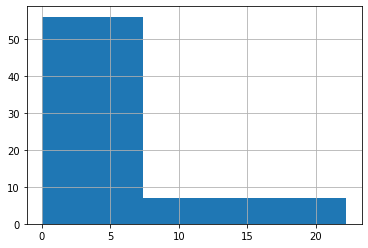

In [20]:
slopes = []
win = []
macd = []
macd_signal = []
bail_outs = []
symbols = []
r_ids = []
scalp = []

for run_id, count in runs.items():
    for symbol in minute_history:
        if symbol not in trade_details[run_id]:
            print(f'1 {symbol}')
            continue
        for trade in trade_details[run_id][symbol]:
            if math.isnan(trade[3]):
                print(f'2 {symbol}')
                continue 
                
            min_time = trade_details[run_id][symbol][0][0]
            max_time = trade_details[run_id][symbol][-1][2]
            
            if min_time is None or max_time is None:
                print(f'3 {symbol}')
                continue
             
            try:
                max_val = minute_history[symbol]['close'][min_time:max_time].max()
            except Exception:
                print(f'4 {symbol}')
                continue
                
            if math.isnan(max_val):
                print(f'5 {symbol}')
                continue
            max_val_index = minute_history[symbol]['close'][min_time:max_time].idxmax()
            
            macds = MACD(
                minute_history[symbol]["close"][:max_val_index]
                .dropna()
                .between_time("9:30", "16:00"),
                13,
                21,
            )
            
            macd_val = macds[0][-1].round(2)
            
            if math.isnan(macd_val):
                print(macds[0][-5])
            macd.append(macd_val)
            macd_signal_val = macds[1][-1].round(2)
            macd_signal.append(macd_signal_val)
            
            bail_out = ((max_val - trade[1]) / trade[1] > 0.003 and macd_val == macd_signal_val)
            bail_outs.append(bail_out)
            #if bail_out == True:
            #     print('bailout!!!')
            
            slope = 100.0 * (max_val - trade[1]) / trade[1]
            slopes.append(slope)
            win.append(trade[3] >= trade[1])
            symbols.append(symbol)
            r_ids.append(run_id)
            #plt.scatter(slope, int(trade[3] >= trade[1]), c=('g' if win else 'r'), s=10)
            
#plt.show()           


d = {
    'symobl':symbols,
    'run': r_ids,
    'win': win,
    'max_val %': slopes,
    'bail_outs': bail_outs,
    'macd': macd,
    'macd_signal': macd_signal,
}
slope_analysis = pd.DataFrame(data=d)
print("all")
display(HTML(slope_analysis.sort_values(by=['win']).to_html()))
print("winners analysis")
display(HTML(slope_analysis.loc[slope_analysis['max_val %'] > 0].sort_values(by=['win']).to_html()))
slope_analysis.loc[slope_analysis['max_val %'] > 0.003]['max_val %'].hist(bins=3)


CODX analysis for run 71
2020-02-26T14:48:41.065406645Z 5.04
2020-02-26T15:32:34.690258743Z 5.2
2020-02-26T15:42:10.379788664Z 5.57
2020-02-26T15:58:01.95392254Z 5.65
2020-02-26T15:58:34.219350405Z 5.81
2020-02-26T16:00:14.925303388Z 5.93


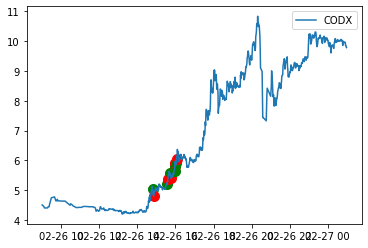

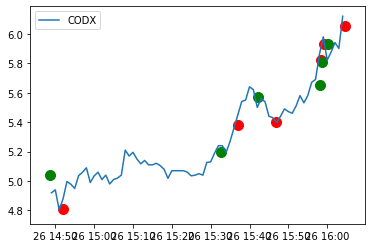

Delta = 0.1899999999999995


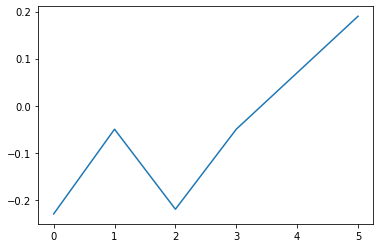

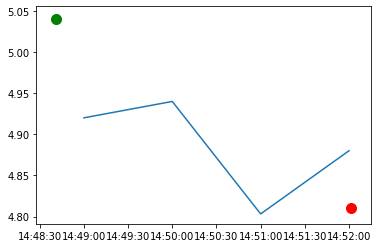

buy time:2020-02-26T14:48:41.065406645Z sell time:2020-02-26T14:52:01.450763147Z
{'rsi': 71.04501086692107, 'macd1': [0.1223210359198692, 0.13866471267788416, 0.15228252537800557, 0.1695126347541347, 0.17358166478096937], 'macd2': [0.06757521795067944, 0.07348813528433862, 0.0792904824429197, 0.08616534804952725, 0.09084923624169239], 'sell_macd': [0.07638019944095209, 0.08663746505994041, 0.0950634192427886, 0.10579710536912756, 0.10790391137187072], 'macd_signal': [0.08436569021333595, 0.0952254947062456, 0.1066369008405976, 0.11921204762330502, 0.13008597105483788], 'sell_macd_signal': [0.052434840090206956, 0.059275365084153646, 0.06643297591588064, 0.07430580180653003, 0.08102542371959817]}
{'rsi': 55.46652321568002, 'macd': [0.09959222306018223, 0.09554176641606738, 0.09217853050615865, 0.08125940472563009, 0.0723190547054049], 'scalp': 0, 'bail_out': 0, 'movement': -0.044603174603174624, 'too_close': 1, 'macd_signal': [0.07936308605726047, 0.08259882212902185, 0.0845147638044492

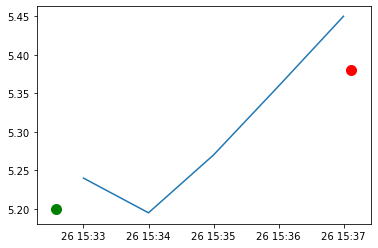

buy time:2020-02-26T15:32:34.690258743Z sell time:2020-02-26T15:37:07.22209599Z
{'rsi': 67.34150961616014, 'macd1': [0.011954006646406334, 0.016374583516567398, 0.019946550198128854, 0.027304113265470775, 0.035150590161359574], 'macd2': [0.08720660791264034, 0.08639134431393103, 0.08556228117203268, 0.08562228780370251, 0.08602036301692007], 'sell_macd': [0.0026766900369254998, 0.005836137924178253, 0.008414459161983245, 0.01343114507245513, 0.01872426207967326], 'macd_signal': [0.027727564810552562, 0.02545696855175553, 0.024354884881030193, 0.02494473055791831, 0.026985902478606563], 'sell_macd_signal': [0.011971400438167426, 0.010744347935369592, 0.010278370180692322, 0.010908925159044885, 0.01247199254317056]}
{'rsi': 73.9715557526312, 'macd': [0.019763223118634876, 0.024440644672558243, 0.025430315433115247, 0.029767327513638087, 0.0384745144917904], 'scalp': 1, 'bail_out': 0, 'movement': 0.030651340996168612, 'too_close': 0, 'macd_signal': [0.012679784750962883, 0.015031956735281

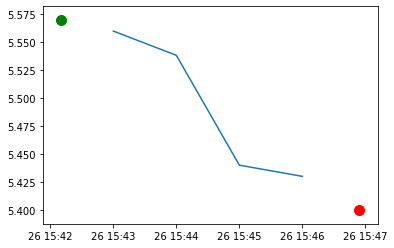

buy time:2020-02-26T15:42:10.379788664Z sell time:2020-02-26T15:46:53.512509361Z
{'rsi': 74.83710630408778, 'macd1': [0.09751932274615616, 0.11173464481658701, 0.12877816330690628, 0.13909227992118112, 0.1419663908876787], 'macd2': [0.09638284765298089, 0.10019926598729967, 0.1049896624380473, 0.10891399014033265, 0.11162419489139186], 'sell_macd': [0.059556512967111175, 0.0686410514316611, 0.07950379502180827, 0.08591237710475674, 0.08743189071348567], 'macd_signal': [0.05925269706261246, 0.06974908661340737, 0.08155490195210716, 0.09306237754592195, 0.1028431802142733], 'sell_macd_signal': [0.0343670290593957, 0.04122183353384878, 0.04887822583144068, 0.05628505608610389, 0.06251442301158025]}
{'rsi': 55.13713094805929, 'macd': [0.08354098162257628, 0.08372507629071357, 0.08165391530107158, 0.07387308965588257, 0.06477279578098294], 'scalp': 0, 'bail_out': 0, 'movement': -0.03137276004950762, 'too_close': 1, 'macd_signal': [0.061736241193398364, 0.0661340082128614, 0.0692379896305034

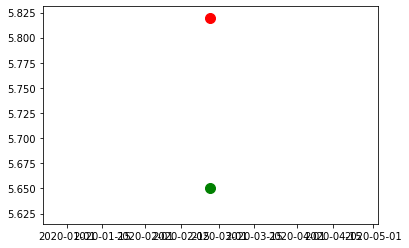

buy time:2020-02-26T15:58:01.95392254Z sell time:2020-02-26T15:58:27.451480943Z
{'rsi': 68.17573991887265, 'macd1': [0.0781147005102163, 0.07960856293701735, 0.0870512350612973, 0.09347781595568971, 0.09665786861134507], 'macd2': [0.10985385173272011, 0.11025786068821564, 0.11189264404041221, 0.11353601305970074, 0.11470804347199337], 'sell_macd': [0.04399434463193064, 0.04498207763949402, 0.04984288157214767, 0.05401697708366804, 0.05605371414350646], 'macd_signal': [0.08698409888248607, 0.08550899169339232, 0.08581744036697332, 0.0873495154847166, 0.08921118611004229], 'sell_macd_signal': [0.05006741120639645, 0.049050344493015964, 0.049208851908842305, 0.050170476943807454, 0.05134712438374726]}
{'rsi': 73.95198418681775, 'macd': [0.04399434463193064, 0.04498207763949402, 0.04984288157214767, 0.05401697708366804, 0.06228748037727261], 'scalp': 1, 'bail_out': 0, 'movement': 0.021126760563380302, 'too_close': 0, 'macd_signal': [0.05006741120639645, 0.049050344493015964, 0.049208851908

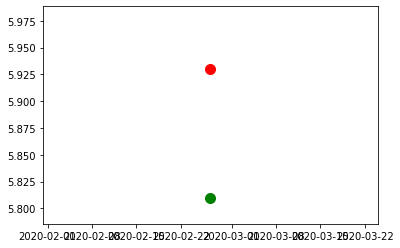

buy time:2020-02-26T15:58:34.219350405Z sell time:2020-02-26T15:59:15.265513036Z
{'rsi': 74.82541975597252, 'macd1': [0.0781147005102163, 0.07960856293701735, 0.0870512350612973, 0.09347781595568971, 0.10823279738627356], 'macd2': [0.10985385173272011, 0.11025786068821564, 0.11189264404041221, 0.11353601305970074, 0.11702871520330049], 'sell_macd': [0.04399434463193064, 0.04498207763949402, 0.04984288157214767, 0.05401697708366804, 0.06359137648116864], 'macd_signal': [0.08698409888248607, 0.08550899169339232, 0.08581744036697332, 0.0873495154847166, 0.091526171865028], 'sell_macd_signal': [0.05006741120639645, 0.049050344493015964, 0.049208851908842305, 0.050170476943807454, 0.05285465685127969]}
{'rsi': 78.06896155988932, 'macd': [0.04498207763949402, 0.04984288157214767, 0.05401697708366804, 0.06540955829935058, 0.07708936758040963], 'scalp': 0, 'bail_out': 0, 'movement': 0.018076942885100637, 'too_close': 0, 'macd_signal': [0.049050344493015964, 0.049208851908842305, 0.050170476943

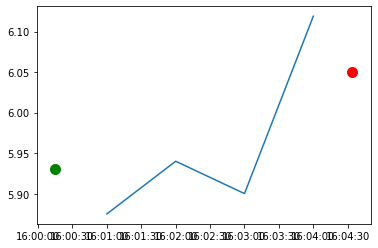

buy time:2020-02-26T16:00:14.925303388Z sell time:2020-02-26T16:04:33.621552924Z
{'rsi': 74.65465005223082, 'macd1': [0.0870512350612973, 0.09347781595568971, 0.11102482017829729, 0.1330160648520975, 0.14479705637883988], 'macd2': [0.11189264404041221, 0.11353601305970074, 0.11758849129286553, 0.12303527196033492, 0.12706122207149306], 'sell_macd': [0.04984288157214767, 0.05401697708366804, 0.06540955829935058, 0.0796296273206698, 0.08711501061883276], 'macd_signal': [0.08581744036697332, 0.0873495154847166, 0.09208457642343273, 0.10027087410916569, 0.10917611056310053], 'sell_macd_signal': [0.049208851908842305, 0.050170476943807454, 0.05321829321491608, 0.05850056003606682, 0.06422345015262002]}
{'rsi': 72.13803245905122, 'macd': [0.08147345217727331, 0.08463651762167501, 0.0893786917650834, 0.0898404028928681, 0.09682043230551951], 'scalp': 1, 'bail_out': 0, 'movement': 0.020236087689713342, 'too_close': 0, 'macd_signal': [0.06309513846430811, 0.06740341429578149, 0.0717984697896418

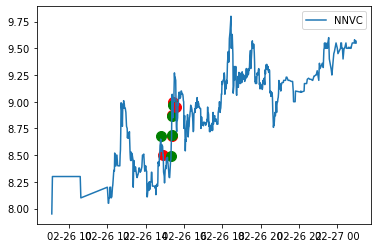

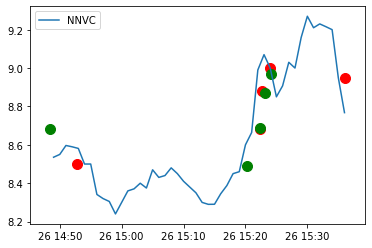

Delta = 0.3100000000000005


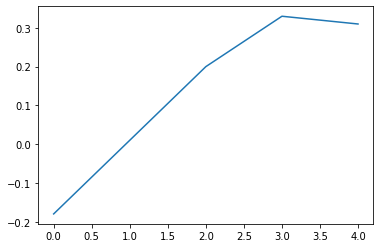

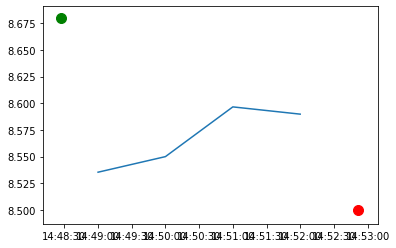

buy time:2020-02-26T14:48:27.325844191Z sell time:2020-02-26T14:52:51.847912677Z
{'rsi': 72.17533041221108, 'macd1': [0.15584894611396116, 0.16010780727831353, 0.16879941864892167, 0.1784717703649381, 0.18640911976791408], 'macd2': [0.05123401973492747, 0.056458542242770804, 0.06261439674959846, 0.06913745298039231, 0.07550810574933742], 'sell_macd': [0.09728683085740819, 0.09950583860561935, 0.10461797660934735, 0.11035966886407955, 0.11495891388251778], 'macd_signal': [0.12428744888611047, 0.1314515205645511, 0.1389211001814252, 0.14683123421812777, 0.15474681132808504], 'sell_macd_signal': [0.07863663300103674, 0.08281047412195326, 0.08717197461943207, 0.09180951346836157, 0.09643939355119281]}
{'rsi': 55.39921242468907, 'macd': [0.1101433294669345, 0.10584821656699184, 0.1018851647414909, 0.09989466767302879, 0.09202811583172021], 'scalp': 0, 'bail_out': 0, 'movement': -0.02073732718894006, 'too_close': 1, 'macd_signal': [0.09547627666807615, 0.09755066464785929, 0.0984175646665856

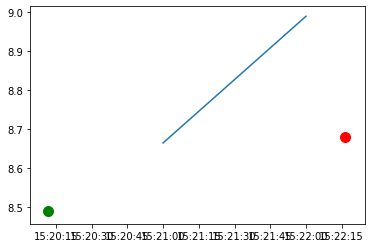

buy time:2020-02-26T15:20:11.555460993Z sell time:2020-02-26T15:22:16.527170624Z
{'rsi': 59.36151148691453, 'macd1': [-0.008260961129892053, -0.005300771551686623, 0.0020167646882374157, 0.008532592059252053, 0.015957441514501625], 'macd2': [0.058642070404125946, 0.05758932592985211, 0.05751866525851135, 0.05752319749930024, 0.05791997314746311], 'sell_macd': [-0.00951649365082119, -0.007263697186475682, -0.002198353224823535, 0.0023018934105518696, 0.007352710354863845], 'macd_signal': [0.010352684757768165, 0.007221993495877207, 0.006180947734349249, 0.00665127659932981, 0.008512509582364172], 'sell_macd_signal': [0.0014335676785489039, -0.0003058852944560135, -0.0006843788805295178, -8.712442231324031e-05, 0.0014008425331221768]}
{'rsi': 70.43047300725802, 'macd': [-0.007263697186475682, -0.002198353224823535, 0.0023018934105518696, 0.013051411653565381, 0.025414004938335566], 'scalp': 1, 'bail_out': 0, 'movement': 0.02234314452963973, 'too_close': 0, 'macd_signal': [-0.000305885294

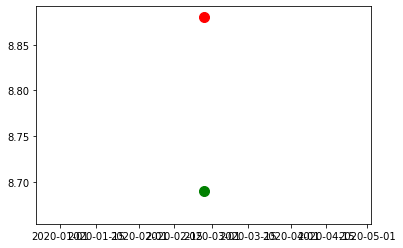

buy time:2020-02-26T15:22:18.03330301Z sell time:2020-02-26T15:22:39.72407816Z
{'rsi': 70.95186489137757, 'macd1': [0.0020167646882374157, 0.008532592059252053, 0.02470843866549899, 0.04222161263146873, 0.057519722005018536], 'macd2': [0.05751866525851135, 0.05752319749930024, 0.059674471348182934, 0.06258506040891199, 0.06557543433418367], 'sell_macd': [-0.002198353224823535, 0.0023018934105518696, 0.013051411653565381, 0.024593225717556066, 0.03460771426459175], 'macd_signal': [0.006180947734349249, 0.00665127659932981, 0.010262709012563646, 0.016654489736344664, 0.02482753619007944], 'sell_macd_signal': [-0.0006843788805295178, -8.712442231324031e-05, 0.002540582792862484, 0.006951111377801201, 0.012482431955159311]}
{'rsi': 77.67325954769511, 'macd': [-0.002198353224823535, 0.0023018934105518696, 0.013051411653565381, 0.024593225717556066, 0.044477844134723554], 'scalp': 1, 'bail_out': 0, 'movement': 0.021864211737629608, 'too_close': 0, 'macd_signal': [-0.0006843788805295178, -8.7

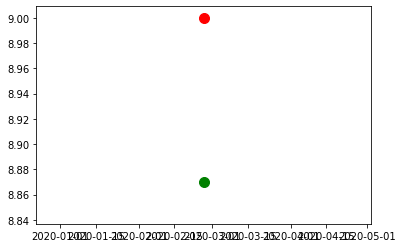

buy time:2020-02-26T15:23:13.70193105Z sell time:2020-02-26T15:23:58.977089447Z
{'rsi': 72.73928782358125, 'macd1': [0.008532592059252053, 0.02470843866549899, 0.04222161263146873, 0.08145134593664238, 0.10407918432745866], 'macd2': [0.05752319749930024, 0.059674471348182934, 0.06258506040891199, 0.07037351510187584, 0.07598716571687092], 'sell_macd': [0.0023018934105518696, 0.013051411653565381, 0.024593225717556066, 0.05019212984900712, 0.06481215735599477], 'macd_signal': [0.00665127659932981, 0.010262709012563646, 0.016654489736344664, 0.02961386097640421, 0.0445069256466151], 'sell_macd_signal': [-8.712442231324031e-05, 0.002540582792862484, 0.006951111377801201, 0.015599315072042385, 0.02544188352883286]}
{'rsi': 80.53596529493522, 'macd': [0.0023018934105518696, 0.013051411653565381, 0.024593225717556066, 0.05019212984900712, 0.07000696255080108], 'scalp': 0, 'bail_out': 0, 'movement': 0.011235955056179735, 'too_close': 0, 'macd_signal': [-8.712442231324031e-05, 0.00254058279286

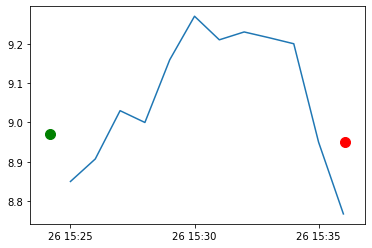

buy time:2020-02-26T15:24:10.282112333Z sell time:2020-02-26T15:36:03.615102812Z
{'rsi': 74.36011626299833, 'macd1': [0.02470843866549899, 0.04222161263146873, 0.08145134593664238, 0.11762448347275622, 0.13746127802700414], 'macd2': [0.059674471348182934, 0.06258506040891199, 0.07037351510187584, 0.07870287943138621, 0.0848040612804386], 'sell_macd': [0.013051411653565381, 0.024593225717556066, 0.05019212984900712, 0.07363293657677517, 0.08627729329222156], 'macd_signal': [0.010262709012563646, 0.016654489736344664, 0.02961386097640421, 0.04721598547567461, 0.06526504398594052], 'sell_macd_signal': [0.002540582792862484, 0.006951111377801201, 0.015599315072042385, 0.02720603937298894, 0.03902029015683546]}
{'rsi': 52.368942735223946, 'macd': [0.13093710907736877, 0.1306019480152365, 0.1278446543562346, 0.11104878066926815, 0.09444097285255104], 'scalp': 0, 'bail_out': 0, 'movement': -0.029411764705882307, 'too_close': 1, 'macd_signal': [0.10419851763866103, 0.10947920371397613, 0.11315

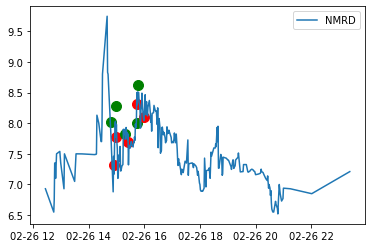

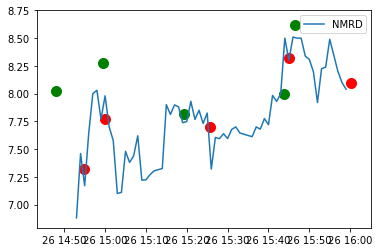

Delta = -1.5299999999999985


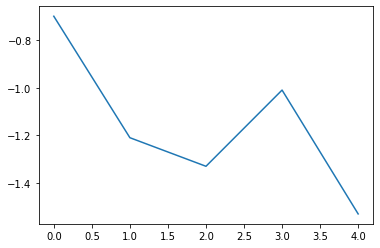

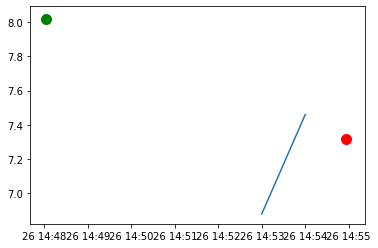

buy time:2020-02-26T14:48:02.276568989Z sell time:2020-02-26T14:54:55.640036232Z
{'rsi': 62.52772656805219, 'macd1': [0.12737105226699352, 0.400759035203218, 0.5373933918033575, 0.6360055698598392, 0.7060178966008444], 'macd2': [0.0025081293642292835, 0.060935976474419284, 0.09995985983893352, 0.1352393944980257, 0.1674813983655108], 'sell_macd': [0.09256304179000185, 0.26978169224955284, 0.35683802127972886, 0.4185333682996095, 0.46117216638913217], 'macd_signal': [-0.10328555643088855, -0.0024766381040672303, 0.10549736787741774, 0.21159900827390205, 0.3104827859392905], 'sell_macd_signal': [-0.059571613700069845, 0.0062990474898547005, 0.07640684224782954, 0.1448321474581855, 0.20810015124437486]}
{'rsi': 46.18371687967603, 'macd': [0.4185333682996095, 0.4196137248306906, 0.4066943438830828, 0.3414754191981535, 0.308038913999531], 'scalp': 0, 'bail_out': 0, 'movement': -0.004092769440654877, 'too_close': 0, 'macd_signal': [0.1448321474581855, 0.19978846293268654, 0.2411696391227658,

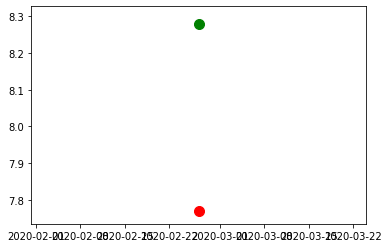

buy time:2020-02-26T14:59:32.028107615Z sell time:2020-02-26T15:00:03.330928317Z
{'rsi': 55.6917038179319, 'macd1': [0.4405767707001136, 0.4295053694272726, 0.4443194525391245, 0.4532556207602152, 0.47503460588203517], 'macd2': [0.1773174791156169, 0.18635735054815328, 0.20006679267693173, 0.21283974716218168, 0.22824926706698445], 'sell_macd': [0.2775994384732021, 0.26843230511275795, 0.2762860673628955, 0.2803761929167319, 0.29290906746625733], 'macd_signal': [0.4217243191013561, 0.4232805291665394, 0.42748831384105646, 0.4326417752248882, 0.4411203413563176], 'sell_macd_signal': [0.27332369295265513, 0.2723454153846757, 0.2731335457803197, 0.27458207520760214, 0.27824747365933317]}
{'rsi': 50.63014115484034, 'macd': [0.26843230511275795, 0.2762860673628955, 0.2803761929167319, 0.2664155609727503, 0.2520927885362356], 'scalp': 0, 'bail_out': 0, 'movement': -0.06155797101449271, 'too_close': 1, 'macd_signal': [0.2723454153846757, 0.2731335457803197, 0.27458207520760214, 0.272948772360

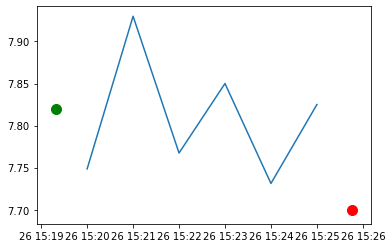

buy time:2020-02-26T15:19:18.780789107Z sell time:2020-02-26T15:25:45.589607897Z
{'rsi': 55.96213297122142, 'macd1': [0.06394441914405746, 0.10128625051352014, 0.12236846881707564, 0.14437569433904063, 0.16167166083814077], 'macd2': [0.19572791998739447, 0.2012070103400676, 0.20451870920457704, 0.2086187268976678, 0.21239788155748762], 'sell_macd': [0.022802179310018822, 0.04791886414388191, 0.062296555389179, 0.07717402187396782, 0.08887108638323227], 'macd_signal': [0.14150625625308139, 0.13346225510516913, 0.13124349784755043, 0.13386993714584847, 0.13943028188430692], 'sell_macd_signal': [0.0722695705195242, 0.06739942924439575, 0.0663788544733524, 0.06853788795347548, 0.07260452763942685]}
{'rsi': 50.77974832566549, 'macd': [0.09172204039305232, 0.08775036979618545, 0.08780685543763767, 0.08053909287983885, 0.0722611078623352], 'scalp': 0, 'bail_out': 0, 'movement': -0.02765151515151519, 'too_close': 1, 'macd_signal': [0.07980097585986672, 0.08139085464713046, 0.0826740548052319, 

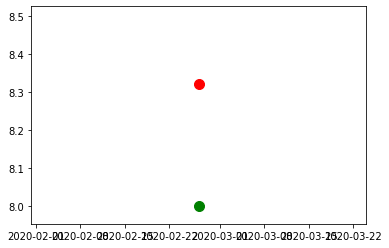

buy time:2020-02-26T15:43:50.685577712Z sell time:2020-02-26T15:44:54.513761062Z
{'rsi': 58.86604787541449, 'macd1': [0.04856566879663404, 0.04832721204435053, 0.06863352413820945, 0.07946914160048468, 0.0926369998219192], 'macd2': [0.16857896132938333, 0.16609231348446318, 0.167757988836283, 0.16816170216262982, 0.1693837323726548], 'sell_macd': [0.022482853385465518, 0.02272469737825933, 0.03632191740669288, 0.043650635384605785, 0.05243079698577713], 'macd_signal': [0.05759350574602708, 0.055740247005691766, 0.0583189024321953, 0.06254895026585318, 0.06856656017706639], 'sell_macd_signal': [0.02655267226063689, 0.025787077284161377, 0.027894045308667677, 0.0310453633238553, 0.035322450056239664]}
{'rsi': 65.1579018140391, 'macd': [0.02272469737825933, 0.03632191740669288, 0.043650635384605785, 0.05243079698577713, 0.07313701645440673], 'scalp': 1, 'bail_out': 0, 'movement': 0.03499999999999992, 'too_close': 0, 'macd_signal': [0.025787077284161377, 0.027894045308667677, 0.03104536332

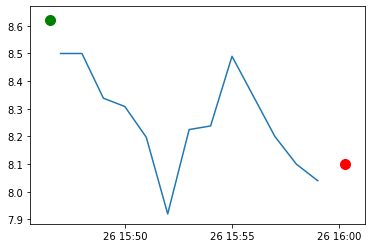

buy time:2020-02-26T15:46:29.594107467Z sell time:2020-02-26T16:00:17.040154389Z
{'rsi': 67.64628703785739, 'macd1': [0.07946914160048468, 0.0926369998219192, 0.14178404543903245, 0.16271937695740846, 0.20279441587400004], 'macd2': [0.16816170216262982, 0.1693837323726548, 0.17823393492514406, 0.1828926235831121, 0.19200420779248883], 'sell_macd': [0.043650635384605785, 0.05243079698577713, 0.0845655878829783, 0.09811781990829171, 0.12402711992920601], 'macd_signal': [0.06254895026585318, 0.06856656017706639, 0.0832100572294596, 0.09911192117504937, 0.11984842011483951], 'sell_macd_signal': [0.0310453633238553, 0.035322450056239664, 0.04517107762158739, 0.055760426078928255, 0.0694137648489838]}
{'rsi': 50.3951537839036, 'macd': [0.08922237123591081, 0.08473143941341199, 0.09321731800090127, 0.08355933614698507, 0.06975364462254419], 'scalp': 0, 'bail_out': 0, 'movement': -0.038004750593824264, 'too_close': 1, 'macd_signal': [0.10351727886696063, 0.0997601109762509, 0.09845155238118097

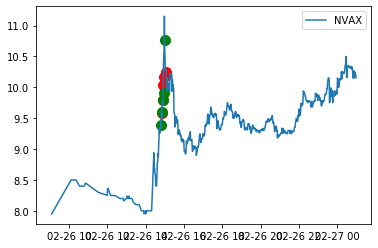

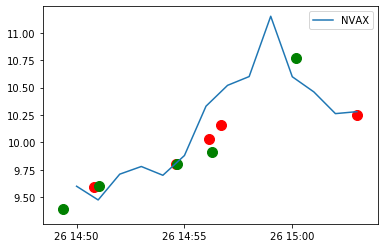

Delta = 0.35999999999999943


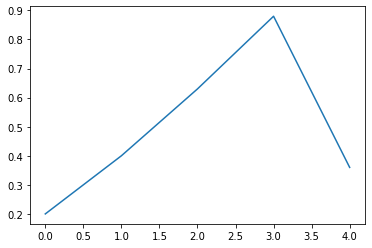

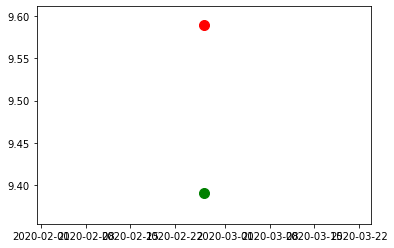

buy time:2020-02-26T14:49:21.233239441Z sell time:2020-02-26T14:50:47.063759671Z
{'rsi': 74.763928401753, 'macd1': [0.3099600224282426, 0.32060405226620325, 0.3276829468427689, 0.34026404149001976, 0.3444804086183204], 'macd2': [0.13295261798980995, 0.14292098983217905, 0.15234343671341222, 0.16292787354942284, 0.17205185502301745], 'sell_macd': [0.19278328937254052, 0.1987190612575258, 0.2023220125801437, 0.20951493552530032, 0.21125078541080633], 'macd_signal': [0.23238958100043622, 0.2500324752535896, 0.2655625695714255, 0.28050286395514434, 0.29329837288777955], 'sell_macd_signal': [0.1451373664886757, 0.15585370544244573, 0.16514736686998532, 0.1740208806010483, 0.1814668615629999]}
{'rsi': 74.52933475027197, 'macd': [0.2023220125801437, 0.20951493552530032, 0.21554169450171656, 0.2103996665027985, 0.21664744122438329], 'scalp': 1, 'bail_out': 0, 'movement': 0.020983934674062402, 'too_close': 0, 'macd_signal': [0.16514736686998532, 0.1740208806010483, 0.18232504338118197, 0.187939

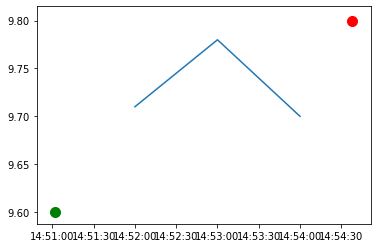

buy time:2020-02-26T14:51:01.540507239Z sell time:2020-02-26T14:54:37.857240017Z
{'rsi': 74.69573026341193, 'macd1': [0.34026404149001976, 0.35106958240749364, 0.3447255522726653, 0.3565674027109331, 0.36178175957611636], 'macd2': [0.16292787354942284, 0.1733729265943893, 0.18053829058882798, 0.19100024556237827, 0.20032010058512384], 'sell_macd': [0.20951493552530032, 0.21554169450171656, 0.2103996665027985, 0.2171669217438641, 0.2196197580129553], 'macd_signal': [0.28050286395514434, 0.2946162076456142, 0.30463807657102443, 0.31502394179900617, 0.3243755053544282], 'sell_macd_signal': [0.1740208806010483, 0.18232504338118197, 0.18793996800550528, 0.19378535875317704, 0.1989522386051327]}
{'rsi': 74.56629099573286, 'macd': [0.2171669217438641, 0.21312625151944964, 0.21941759613004308, 0.22510672704569856, 0.22765531312223963], 'scalp': 1, 'bail_out': 0, 'movement': 0.020833333333333447, 'too_close': 0, 'macd_signal': [0.19378535875317704, 0.19765353730643156, 0.20200634907115386, 0.20

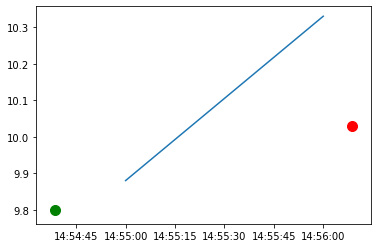

buy time:2020-02-26T14:54:38.526646279Z sell time:2020-02-26T14:56:08.603019942Z
{'rsi': 74.56629099573286, 'macd1': [0.3565674027109331, 0.3518102496046076, 0.3628203404802264, 0.37289582090437, 0.3781356323944589], 'macd2': [0.19100024556237827, 0.1983209002652515, 0.20849744679474114, 0.21864628477042025, 0.22795371821422528], 'sell_macd': [0.2171669217438641, 0.21312625151944964, 0.21941759613004308, 0.22510672704569856, 0.22765531312223963], 'macd_signal': [0.31502394179900617, 0.32238120336012643, 0.3304690307841464, 0.3389543888081911, 0.3467906375254447], 'sell_macd_signal': [0.19378535875317704, 0.19765353730643156, 0.20200634907115386, 0.2066264246660628, 0.21083220235729816]}
{'rsi': 75.59173312186189, 'macd': [0.21941759613004308, 0.22510672704569856, 0.2224605079274351, 0.22686007084921123, 0.2335238851928132], 'scalp': 1, 'bail_out': 0, 'movement': 0.020306122448979575, 'too_close': 0, 'macd_signal': [0.20200634907115386, 0.2066264246660628, 0.20979324131833726, 0.2132066

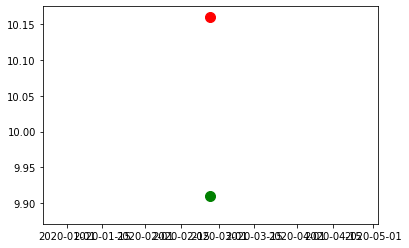

buy time:2020-02-26T14:56:17.801558195Z sell time:2020-02-26T14:56:41.428830259Z
{'rsi': 74.20317362795008, 'macd1': [0.3628203404802264, 0.37289582090437, 0.37015842441725155, 0.3781543852958098, 0.3825027377186583], 'macd2': [0.20849744679474114, 0.21864628477042025, 0.22635435795832848, 0.23596285814766915, 0.24490540413050965], 'sell_macd': [0.21941759613004308, 0.22510672704569856, 0.2224605079274351, 0.22686007084921123, 0.22890050856943667], 'macd_signal': [0.3304690307841464, 0.3389543888081911, 0.3451951959300032, 0.3517870338031645, 0.35793017458626325], 'sell_macd_signal': [0.20200634907115386, 0.2066264246660628, 0.20979324131833726, 0.21320660722451207, 0.216345387493497]}
{'rsi': 77.63426277497659, 'macd': [0.21941759613004308, 0.22510672704569856, 0.2224605079274351, 0.22686007084921123, 0.24136804103696718], 'scalp': 1, 'bail_out': 0, 'movement': 0.02421796165489407, 'too_close': 0, 'macd_signal': [0.20200634907115386, 0.2066264246660628, 0.20979324131833726, 0.21320660

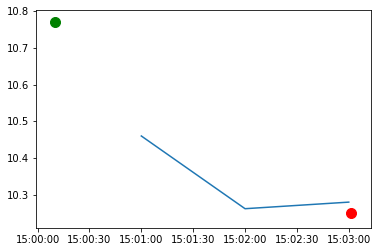

buy time:2020-02-26T15:00:10.112369705Z sell time:2020-02-26T15:03:01.373237058Z
{'rsi': 74.87536988922972, 'macd1': [0.4160070112229324, 0.45607950149377885, 0.48865960638981143, 0.5524912030304083, 0.5690909872584502], 'macd2': [0.2516227172052794, 0.2686666375662323, 0.2851973829481942, 0.30874654552000536, 0.3244825058941192], 'sell_macd': [0.2507186903876182, 0.27592386547744674, 0.29613667898280127, 0.33661242094823685, 0.3461232274024937], 'macd_signal': [0.3646310292871181, 0.38292072372845026, 0.4040685002607225, 0.43375304081465965, 0.4608206301034178], 'sell_macd_signal': [0.22070902385713329, 0.23175199218119596, 0.24462892954151702, 0.263025627822861, 0.2796451477387875]}
{'rsi': 60.49702286013897, 'macd': [0.33661242094823685, 0.33512062999989745, 0.3224215639362562, 0.2980583752641177, 0.274574612983697], 'scalp': 0, 'bail_out': 0, 'movement': -0.051812656682176876, 'too_close': 1, 'macd_signal': [0.263025627822861, 0.27744462825826827, 0.2864400153938659, 0.288763687367

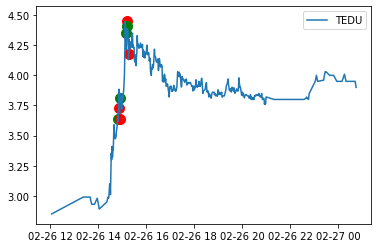

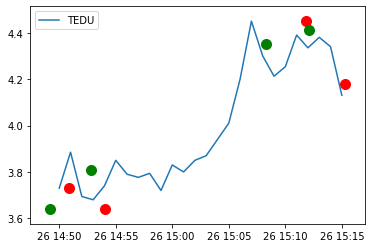

Delta = -0.20999999999999996


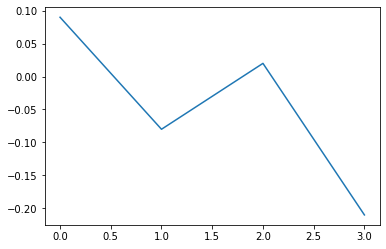

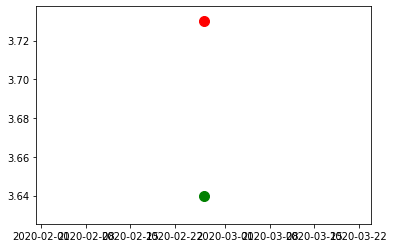

buy time:2020-02-26T14:49:10.606504032Z sell time:2020-02-26T14:50:51.352680071Z
{'rsi': 74.1973737297801, 'macd1': [0.17499945938692818, 0.1728156999457946, 0.17321172089709114, 0.17633439576324017, 0.17672356386904653], 'macd2': [0.09077701847132724, 0.09449387047774715, 0.09857963656525692, 0.10314062385877865, 0.10716232288595151], 'sell_macd': [0.10649573389833655, 0.1045814253344326, 0.10438610144912497, 0.1059951204807148, 0.10584117270687932], 'macd_signal': [0.1661275341243569, 0.16746516728864444, 0.16861447801033377, 0.17015846156091505, 0.17147148202254134], 'sell_macd_signal': [0.10291641038907272, 0.1032494133781447, 0.10347675099234074, 0.10398042489001555, 0.1043525744533883]}
{'rsi': 75.27744939218866, 'macd': [0.1045814253344326, 0.10438610144912497, 0.1059951204807148, 0.10431389997960672, 0.10736341777121616], 'scalp': 1, 'bail_out': 0, 'movement': 0.022085822326957858, 'too_close': 0, 'macd_signal': [0.1032494133781447, 0.10347675099234074, 0.10398042489001555, 0.1

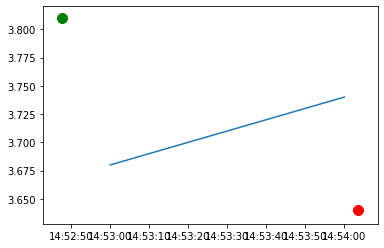

buy time:2020-02-26T14:52:47.616582257Z sell time:2020-02-26T14:54:03.447825218Z
{'rsi': 72.87148855694282, 'macd1': [0.17633439576324017, 0.1743782647237473, 0.17964137271589653, 0.19407439039959318, 0.19718773028967318], 'macd2': [0.10314062385877865, 0.10669211097071729, 0.11154984923568678, 0.11831812446589529, 0.1231564006781487], 'sell_macd': [0.1059951204807148, 0.10431389997960672, 0.10736861257641106, 0.11640126378721405, 0.11803188468151227], 'macd_signal': [0.17015846156091505, 0.1710024221934815, 0.1727302122979645, 0.17699904791829024, 0.18103678439256682], 'sell_macd_signal': [0.10398042489001555, 0.10404711990793378, 0.10471141844162923, 0.10704938751074619, 0.10924588694489941]}
{'rsi': 60.74764658060071, 'macd': [0.10736861257641106, 0.11640126378721405, 0.11200591065553844, 0.10639906521974485, 0.09876257442276648], 'scalp': 0, 'bail_out': 0, 'movement': -0.04364829396325462, 'too_close': 1, 'macd_signal': [0.10471141844162923, 0.10704938751074619, 0.10804069213970464

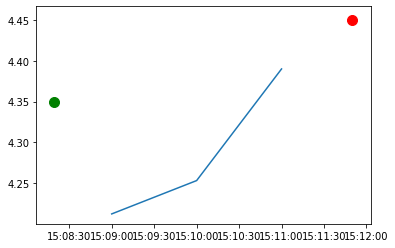

buy time:2020-02-26T15:08:19.537547573Z sell time:2020-02-26T15:11:49.969752423Z
{'rsi': 74.58133308172592, 'macd1': [0.14349031497388154, 0.14945343311875048, 0.16755498228502974, 0.1997706691556469, 0.21475708286731976], 'macd2': [0.14625648523396118, 0.14924901165335225, 0.15479751514971607, 0.16365313949379168, 0.16993949657405683], 'sell_macd': [0.08122700133920802, 0.08512965851758736, 0.0969196555589531, 0.11783498240210921, 0.1274075100409049], 'macd_signal': [0.15256268324943106, 0.15194083322329494, 0.1550636630356419, 0.1640050642596429, 0.17415546798117826], 'sell_macd_signal': [0.08751539171164865, 0.08703824507283639, 0.08901452717005973, 0.09477861821646963, 0.10130439658135668]}
{'rsi': 72.52967841702429, 'macd': [0.11783498240210921, 0.12481010744350218, 0.12408409958687905, 0.12402637788578508, 0.1325836547695327], 'scalp': 1, 'bail_out': 0, 'movement': 0.02298850574712656, 'too_close': 0, 'macd_signal': [0.09477861821646963, 0.10078491606187615, 0.10544475276687673, 

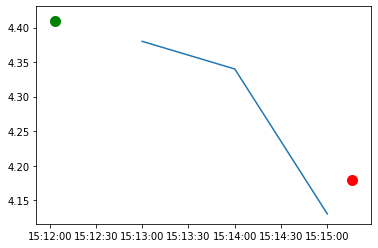

buy time:2020-02-26T15:12:03.281251857Z sell time:2020-02-26T15:15:15.663913633Z
{'rsi': 71.68521866938222, 'macd1': [0.21076847887871564, 0.21001099670871293, 0.21027894091502164, 0.218989393601845, 0.22491365831543186], 'macd2': [0.16913981644610798, 0.17251937838193188, 0.17600530181288043, 0.18111569309931053, 0.18584761935987792], 'sell_macd': [0.12481010744350218, 0.12408409958687905, 0.12402637788578508, 0.1294667716526492, 0.133063613917054], 'macd_signal': [0.17335774718345745, 0.18068839708850853, 0.18660650585381117, 0.19308308340341793, 0.1994491983858207], 'sell_macd_signal': [0.10078491606187615, 0.10544475276687673, 0.1091610777906584, 0.11322221656305656, 0.11719049603385605]}
{'rsi': 57.74760286485208, 'macd': [0.1294667716526492, 0.12916751002095062, 0.12959448134662832, 0.12616621898551195, 0.11354463508093371], 'scalp': 0, 'bail_out': 0, 'movement': -0.052154195011337966, 'too_close': 1, 'macd_signal': [0.11322221656305656, 0.11641127525463538, 0.11904791647303396, 

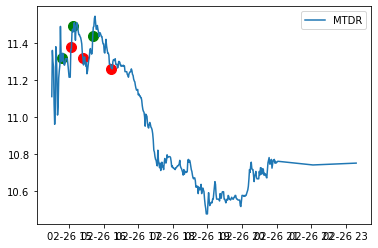

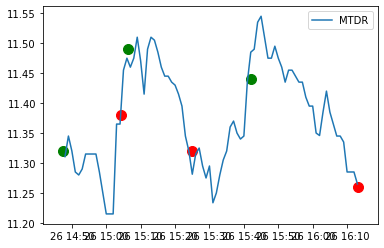

Delta = -0.28999999999999915


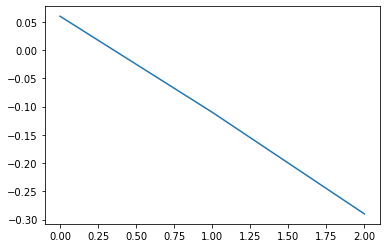

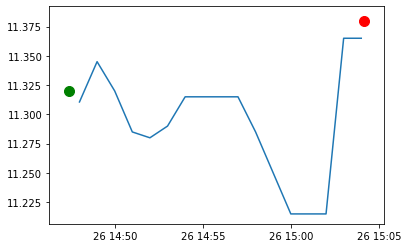

buy time:2020-02-26T14:47:24.901281053Z sell time:2020-02-26T15:04:09.438945248Z
{'rsi': 55.781703568427496, 'macd1': [0.07989274508353894, 0.08362171848212796, 0.08798348717353299, 0.10715030324601749, 0.10937900184131522], 'macd2': [0.0484666372858964, 0.05095499751862498, 0.053642681207323406, 0.0593882987374581, 0.062260394995709234], 'sell_macd': [0.04800134211159346, 0.050221080170315346, 0.05285696592814482, 0.06513353968842672, 0.06632134340178375], 'macd_signal': [0.08499494180595454, 0.08472029714118923, 0.08537293514765798, 0.08972840876732988, 0.09365852738212695], 'sell_macd_signal': [0.05253904617013386, 0.052075452970170154, 0.052231755561765084, 0.05481211238709741, 0.05711395859003468]}
{'rsi': 58.70968651006895, 'macd': [0.02427485032782073, 0.018999412481887745, 0.014641936076202455, 0.018848552694159082, 0.02266087015368079], 'scalp': 0, 'bail_out': 1, 'movement': 0.003085059497576037, 'too_close': 0, 'macd_signal': [0.03894957058490951, 0.03495953896430516, 0.03089

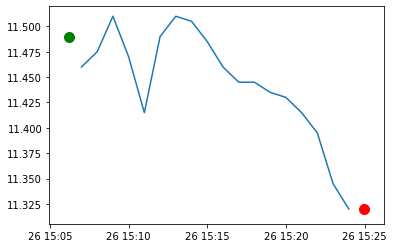

buy time:2020-02-26T15:06:11.732781367Z sell time:2020-02-26T15:24:58.460501255Z
{'rsi': 64.84394824074558, 'macd1': [0.03156935544475381, 0.037750292827569254, 0.042162704818920815, 0.05231872327574827, 0.06326923661627326], 'macd2': [0.06609600906956281, 0.06699912149603193, 0.06772285808432521, 0.06971982987853842, 0.07216531279695992], 'sell_macd': [0.014641936076202455, 0.018848552694159082, 0.021881649374460466, 0.02863624874385806, 0.03586533593113117], 'macd_signal': [0.056688862738994726, 0.052901148756709634, 0.05075345996915187, 0.05106651263047115, 0.05350705742763157], 'sell_macd_signal': [0.03089601838668462, 0.02848652524817951, 0.027165550073435702, 0.027459689807520175, 0.029140819032242374]}
{'rsi': 41.839210534474574, 'macd': [0.024627097063406822, 0.02091192805884745, 0.01670644665193244, 0.010615078716000426, 0.004691739042339549], 'scalp': 0, 'bail_out': 0, 'movement': -0.015217391304347887, 'too_close': 1, 'macd_signal': [0.03342847964973359, 0.03092516933155636,

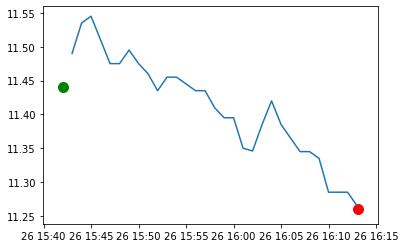

buy time:2020-02-26T15:42:01.744369448Z sell time:2020-02-26T16:13:03.550128447Z
{'rsi': 62.081288415862964, 'macd1': [-0.009973144143657464, -0.008263819915830695, -0.006431570792424068, 0.0022567334585925636, 0.009436952077381378], 'macd2': [0.03858862546582564, 0.037531709449055484, 0.036579254194204935, 0.03708388571831911, 0.03756882038209852], 'sell_macd': [-0.007426217546079528, -0.006151406526507586, -0.004818418634288335, 0.0009581747704832111, 0.005706712816143877], 'macd_signal': [-0.015770751703015146, -0.014269365345578256, -0.012701806434947418, -0.009710098456239422, -0.005880688349515262], 'sell_macd_signal': [-0.012217412818663358, -0.011004211560232204, -0.00976705297504343, -0.007622007425938101, -0.0049562633775217056]}
{'rsi': 30.010630080313216, 'macd': [-0.012731023469571667, -0.01636367365046887, -0.018981794912852124, -0.02077537258596962, -0.022942116583386962], 'scalp': 0, 'bail_out': 0, 'movement': -0.015297202797202704, 'too_close': 1, 'macd_signal': [-0.00

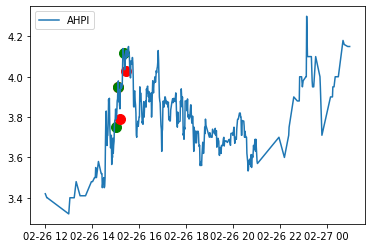

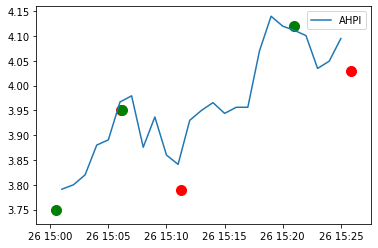

Delta = -0.04999999999999982


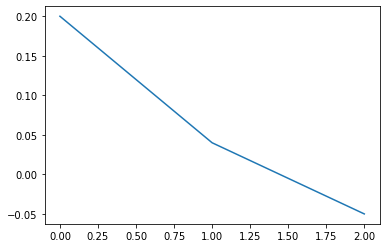

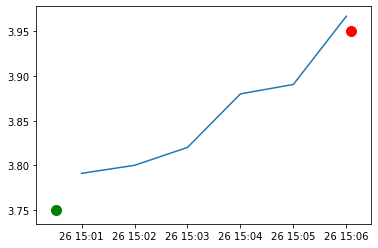

buy time:2020-02-26T15:00:31.070236918Z sell time:2020-02-26T15:06:05.518276117Z
{'rsi': 59.119002568834624, 'macd1': [0.025001485079744423, 0.03079878349342602, 0.03664910238171304, 0.04126973282260238, 0.045823563135861445], 'macd2': [0.07237308830059597, 0.07273171003567924, 0.07327799623011533, 0.07375456262294922, 0.0743565462372704], 'sell_macd': [0.011105108745574466, 0.01506612064988655, 0.019037479008443103, 0.02218090787214333, 0.0252565549364272], 'macd_signal': [0.043752926700180585, 0.04116209805882967, 0.04025949892340634, 0.04046154570324555, 0.04153394918976873], 'sell_macd_signal': [0.02302406602835568, 0.021432476952661855, 0.020953477363818106, 0.02119896346548315, 0.02201048175967196]}
{'rsi': 63.728568872681876, 'macd': [0.027744518287226683, 0.028486981227448194, 0.029734524022069664, 0.03343735575785178, 0.03716115508757989], 'scalp': 1, 'bail_out': 0, 'movement': 0.02544910179640724, 'too_close': 0, 'macd_signal': [0.023424925428819306, 0.024437336588545085, 0.0

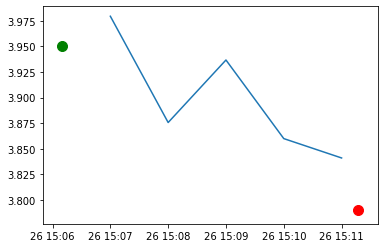

buy time:2020-02-26T15:06:09.654293382Z sell time:2020-02-26T15:11:16.785338642Z
{'rsi': 66.28589821397988, 'macd1': [0.050571677173554264, 0.05240836775282132, 0.058036448773582716, 0.06263011397476514, 0.07025386746315831], 'macd2': [0.0751401842512891, 0.07546980998170305, 0.07661198893642318, 0.07770983212677329, 0.07954561695383777], 'sell_macd': [0.028486981227448194, 0.029734524022069664, 0.03343735575785178, 0.03643907716550254, 0.041390560377106755], 'macd_signal': [0.044949358354019434, 0.04644116023377981, 0.04876021794174039, 0.05153419714834534, 0.05527813121130794], 'sell_macd_signal': [0.024437336588545085, 0.02549677407525, 0.027084890411770358, 0.028955727762516793, 0.03144269428543479]}
{'rsi': 49.872605608608325, 'macd': [0.046915265941041895, 0.04453578613465359, 0.045272090361692996, 0.04127346910533802, 0.034011251644472384], 'scalp': 0, 'bail_out': 0, 'movement': -0.05942928039702234, 'too_close': 1, 'macd_signal': [0.034678507317854844, 0.03664996308121459, 0.03

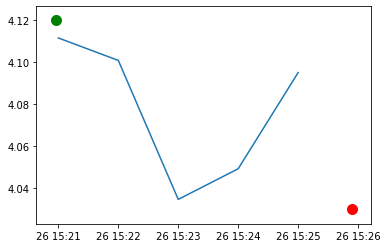

buy time:2020-02-26T15:20:57.231137567Z sell time:2020-02-26T15:25:53.914868058Z
{'rsi': 68.26780692027344, 'macd1': [0.06576462046745002, 0.0644862588493278, 0.07181191560037936, 0.08231706643837855, 0.0880140698990517], 'macd2': [0.08335928540073922, 0.08340044723018725, 0.08512180332000696, 0.08768891773399945, 0.08959062688860175], 'sell_macd': [0.03793478123263805, 0.037073271468409, 0.04182179280188736, 0.048615162765612396, 0.05223837101311757], 'macd_signal': [0.0661378336164043, 0.06580751866298899, 0.06700839805046707, 0.07007013172804936, 0.07365891936224983], 'sell_macd_signal': [0.03831489403333072, 0.03806656952034638, 0.03881761417665457, 0.04077712389444614, 0.04306937331818043]}
{'rsi': 57.85762036534402, 'macd': [0.05394686612788613, 0.05402170821565555, 0.049939485060467526, 0.04686840876992493, 0.04296798037768523], 'scalp': 0, 'bail_out': 0, 'movement': -0.02135922330097089, 'too_close': 1, 'macd_signal': [0.045244871880121565, 0.04700023914722836, 0.04758808832987

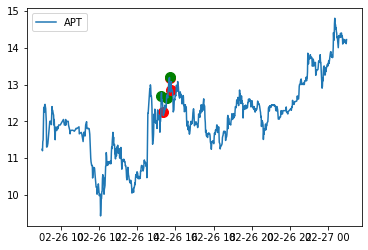

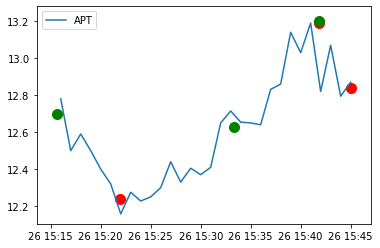

Delta = -0.2599999999999998


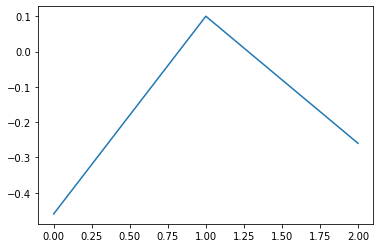

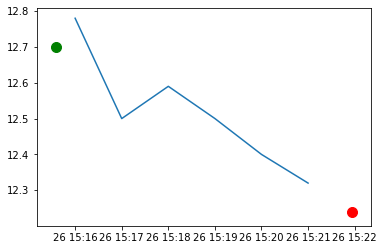

buy time:2020-02-26T15:15:34.867379198Z sell time:2020-02-26T15:21:56.494137532Z
{'rsi': 63.868493570136145, 'macd1': [0.09329114053541154, 0.08239979102448558, 0.0746108443589506, 0.08279886797587821, 0.12895417003500143], 'macd2': [0.2975587192165108, 0.2916145054004584, 0.28601670691491776, 0.283444695262423, 0.2887817693953938], 'sell_macd': [0.04073379135631505, 0.034463694484452745, 0.030226428162423602, 0.036391851441848644, 0.06721696242007802], 'macd_signal': [0.14985049683566146, 0.13636035567342628, 0.12401045341053114, 0.11576813632360056, 0.11840534306588073], 'sell_macd_signal': [0.07492381238793983, 0.06683178880724241, 0.059510716678278654, 0.054886943630992654, 0.05735294738880973]}
{'rsi': 50.3762769356403, 'macd': [0.09912634975722767, 0.1070346212881379, 0.10713672090588489, 0.10062489306379341, 0.08437379483536134], 'scalp': 0, 'bail_out': 0, 'movement': -0.03858267716535421, 'too_close': 1, 'macd_signal': [0.07126372303492655, 0.07841790268556882, 0.08416166632963

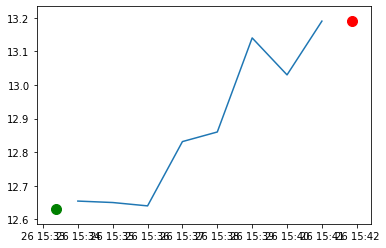

buy time:2020-02-26T15:33:22.071213841Z sell time:2020-02-26T15:41:51.316762706Z
{'rsi': 61.07604161941054, 'macd1': [0.08557207644187947, 0.08219404790667895, 0.08180164323771422, 0.09970729036900572, 0.1131740248408839], 'macd2': [0.2502326844671785, 0.24629149511075532, 0.24291131010892641, 0.24325139370363047, 0.24329038881622544], 'sell_macd': [0.043492165923604276, 0.04166990168941531, 0.041786710056419096, 0.05380257748451989, 0.06284088226635909], 'macd_signal': [0.10430501106049635, 0.09988281842973287, 0.09626658339132914, 0.09695472478686445, 0.10019858479766834], 'sell_macd_signal': [0.054186120412693294, 0.0516828766680377, 0.04970364334571398, 0.05052343017347516, 0.05298692059205194]}
{'rsi': 69.70143222262712, 'macd': [0.08479471623128632, 0.09270455234045016, 0.11220956031719531, 0.12023671510015, 0.13311713811154213], 'scalp': 1, 'bail_out': 0, 'movement': 0.02071207430340556, 'too_close': 0, 'macd_signal': [0.0677254636166778, 0.07272128136143227, 0.08061893715258488

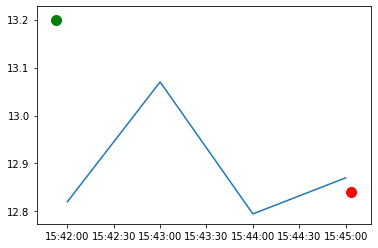

buy time:2020-02-26T15:41:52.909326352Z sell time:2020-02-26T15:45:03.667567682Z
{'rsi': 69.92836157068568, 'macd1': [0.14618738380825924, 0.1583445457345043, 0.18840107378800575, 0.20102768609444688, 0.22219067082348865], 'macd2': [0.24288195964951953, 0.2442505515856368, 0.24959726403612237, 0.25235791829138954, 0.2572131097221], 'sell_macd': [0.08479471623128632, 0.09270455234045016, 0.11220956031719531, 0.12023671510015, 0.1337612939556969], 'macd_signal': [0.12123451429852727, 0.1286565205857227, 0.1406054312261793, 0.15268988219983282, 0.16659003992456398], 'sell_macd_signal': [0.0677254636166778, 0.07272128136143227, 0.08061893715258488, 0.0885424927420979, 0.0975862529848177]}
{'rsi': 54.269070418917586, 'macd': [0.13324181343621788, 0.1224244639132035, 0.12539244527301996, 0.11178058080959019, 0.10103132823017091], 'scalp': 0, 'bail_out': 0, 'movement': -0.028787878787878713, 'too_close': 1, 'macd_signal': [0.0974823568809219, 0.10247077828737822, 0.10705511168450657, 0.108000

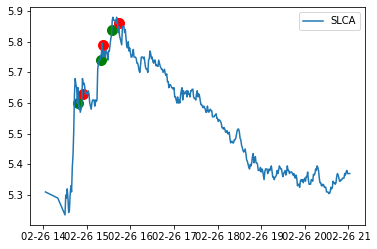

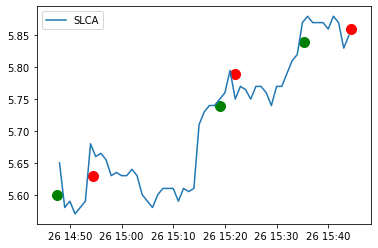

Delta = 0.10000000000000053


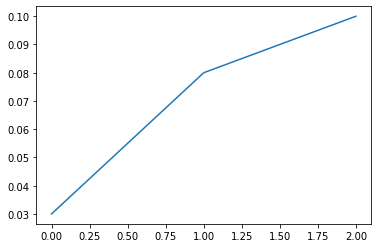

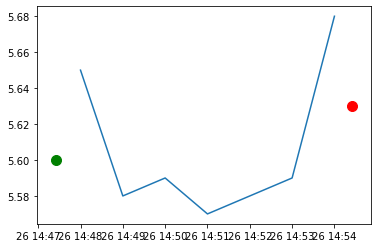

buy time:2020-02-26T14:47:25.20869913Z sell time:2020-02-26T14:54:24.210797079Z
{'rsi': 72.56561921926465, 'macd1': [0.05261467911377693, 0.07149258102636935, 0.08945683373821378, 0.10091649801401026, 0.10475621791084144], 'macd2': [0.012437672781357989, 0.017747712580419517, 0.023404414190702383, 0.02825145647318905, 0.03186602603180955], 'sell_macd': [0.0338812236351842, 0.04594803687585003, 0.05735142333772192, 0.06445339430362562, 0.06655293798739947], 'macd_signal': [0.02872679338413296, 0.03727995091258024, 0.047715327477706945, 0.05835556158496761, 0.06763569285014237], 'sell_macd_signal': [0.018834149663369992, 0.024256927105866, 0.030875826352237186, 0.03759133994251487, 0.043383659551491795]}
{'rsi': 67.59140149686286, 'macd': [0.06471132390103129, 0.06121448890051173, 0.05821416956373682, 0.055639710735552406, 0.05498896735338832], 'scalp': 0, 'bail_out': 1, 'movement': 0.0035650623885917243, 'too_close': 1, 'macd_signal': [0.05462001150802774, 0.05593890698652454, 0.0563939

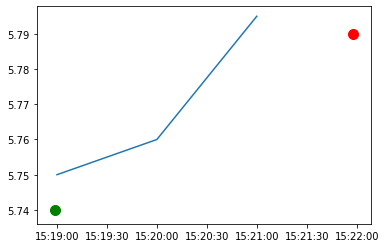

buy time:2020-02-26T15:18:58.849812952Z sell time:2020-02-26T15:21:57.659997839Z
{'rsi': 72.89456275736305, 'macd1': [0.02326703318401968, 0.02976704020325105, 0.03611585436130138, 0.041476140617764834, 0.0452031325210589], 'macd2': [0.05277826123989193, 0.053726044304184484, 0.05483197979147825, 0.05592171575193294, 0.05683486872354315], 'sell_macd': [0.010667205442997485, 0.015068854859485725, 0.01934197317285946, 0.02293996181739999, 0.025445667750582324], 'macd_signal': [0.034508764318608, 0.033560419495536606, 0.03407150646868956, 0.03555243329850462, 0.03748257314301547], 'sell_macd_signal': [0.017540251795585448, 0.017045972408365504, 0.017505172561264295, 0.018592130412491435, 0.019962837880109614]}
{'rsi': 78.02781486136512, 'macd': [0.02293996181739999, 0.025445667750582324, 0.027587183182275155, 0.0294171019188898, 0.032279154156266365], 'scalp': 0, 'bail_out': 0, 'movement': 0.009581881533100996, 'too_close': 0, 'macd_signal': [0.018592130412491435, 0.019962837880109614, 0.

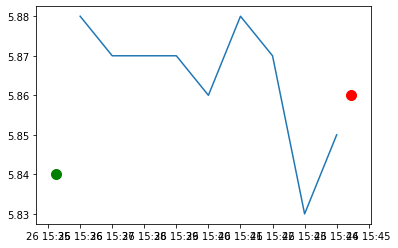

buy time:2020-02-26T15:35:14.579014083Z sell time:2020-02-26T15:44:27.475919428Z
{'rsi': 72.74494759460866, 'macd1': [0.040738301143240285, 0.04074120226127409, 0.041874629607183245, 0.043083159526545955, 0.04513447887047395], 'macd2': [0.0603874618216933, 0.060394995166181964, 0.060625204780337505, 0.060899979471681576, 0.06137525202141969], 'sell_macd': [0.022652876306755054, 0.022689127006986887, 0.023461671357726033, 0.02427843745755176, 0.025638535230695148], 'macd_signal': [0.045838023031377795, 0.04481865887735705, 0.04422985302332229, 0.044000514323967024, 0.04422730723326841], 'sell_macd_signal': [0.025910779697567603, 0.02526644915945146, 0.024905493599106373, 0.024780082370795452, 0.02495177294277539]}
{'rsi': 62.923580396709625, 'macd': [0.029902241728996692, 0.029770174789080173, 0.028761159319157237, 0.025523469870916138, 0.024227562899937105], 'scalp': 0, 'bail_out': 1, 'movement': 0.0034246575342466545, 'too_close': 1, 'macd_signal': [0.0287385291039498, 0.0289448582409

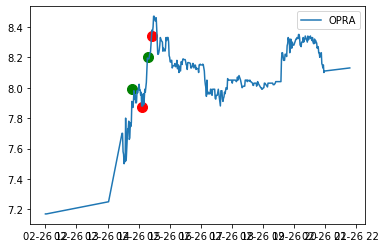

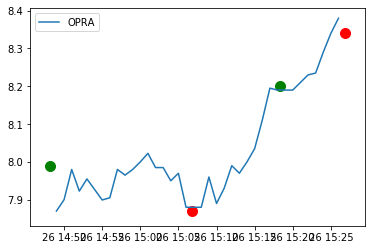

Delta = 0.020000000000000462


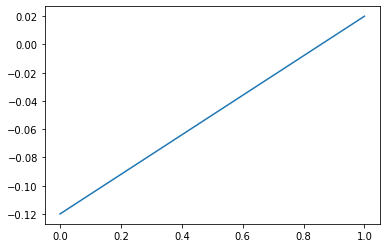

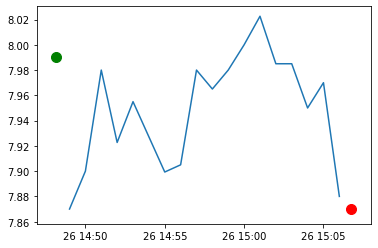

buy time:2020-02-26T14:48:09.704575163Z sell time:2020-02-26T15:06:45.716218115Z
{'rsi': 69.5570188109444, 'macd1': [0.14225387268705436, 0.14463546292240093, 0.14285881181992455, 0.1530012212203209, 0.16558571609276473], 'macd2': [0.05866813248302627, 0.06285836033453407, 0.06621313076435431, 0.07183267264198712, 0.07816743280586813], 'sell_macd': [0.08802506460257753, 0.08909498630113966, 0.08747291247792699, 0.09364437557051541, 0.10139299128460255], 'macd_signal': [0.12543112213920649, 0.12927199029584538, 0.13198935460066122, 0.13619172792459316, 0.14207052555822747], 'sell_macd_signal': [0.07892794556674332, 0.08096135371362259, 0.08226366546648348, 0.08453980748728987, 0.0879104442467524]}
{'rsi': 51.811305828304825, 'macd': [0.07313500281945906, 0.06910986526424434, 0.0632576819060997, 0.058914971732140664, 0.04957110702863865], 'scalp': 0, 'bail_out': 0, 'movement': -0.015018773466833555, 'too_close': 1, 'macd_signal': [0.0815962383983816, 0.07909896377155415, 0.07593070739846

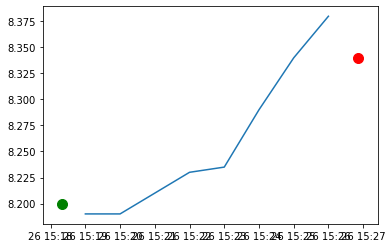

buy time:2020-02-26T15:18:19.695667378Z sell time:2020-02-26T15:26:51.04125043Z
{'rsi': 71.1293500157797, 'macd1': [0.05641159071845436, 0.05907729636505099, 0.06647547262531806, 0.07829483610415622, 0.08706163272029244], 'macd2': [0.1046916659541921, 0.10484525469846151, 0.10601839611460395, 0.10828761835134237, 0.11028215249501727], 'sell_macd': [0.02844573229857339, 0.030434322044105677, 0.0354847254556363, 0.043374848562599766, 0.04921942697630399], 'macd_signal': [0.06976923347374958, 0.06763084605200986, 0.0673997713666715, 0.06957878431416845, 0.07307535399539325], 'sell_macd_signal': [0.03638639602060745, 0.035195981225307094, 0.03525373007137293, 0.0368779537696183, 0.03934624841095544]}
{'rsi': 78.28982956876328, 'macd': [0.05804165309826814, 0.058966832175602946, 0.06178428558423121, 0.06576951829765498, 0.06802074484970433], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.048972003760240676, 0.05097096944331313, 0.05313363267149675, 0.055660809

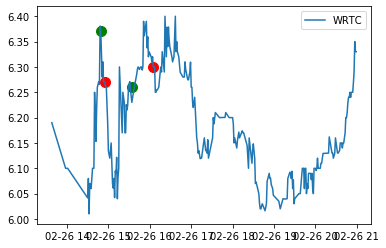

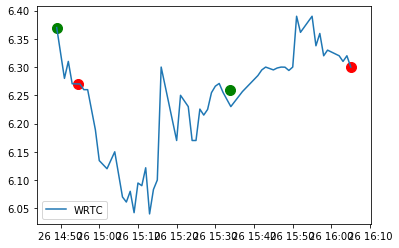

Delta = -0.0600000000000005


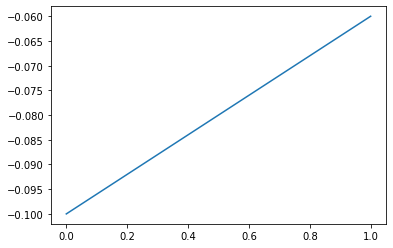

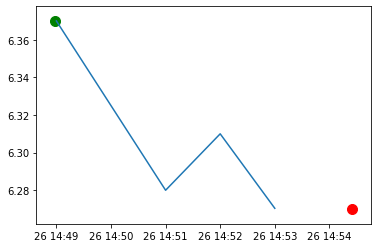

buy time:2020-02-26T14:48:58.746629151Z sell time:2020-02-26T14:54:25.25031977Z
{'rsi': 74.19811920382887, 'macd1': [0.08351847514575095, 0.08839029721574843, 0.09207744787212047, 0.0935021106613334, 0.10271058309548753], 'macd2': [0.028960210596199687, 0.03229160108429863, 0.035480870619995386, 0.03827518718103473, 0.042620897560174065], 'sell_macd': [0.051585859748952245, 0.05449421738080318, 0.056624181543533325, 0.057278385026913625, 0.06300791520841909], 'macd_signal': [0.06963406621379704, 0.07338531241418732, 0.07712373950577395, 0.08039941373688583, 0.08486164760860618], 'sell_macd_signal': [0.043502192168980956, 0.0457005972113454, 0.04788531407778299, 0.049763928267609114, 0.05241272565577111]}
{'rsi': 59.218291914673514, 'macd': [0.06610355021727532, 0.06531958333823784, 0.06152273144108822, 0.059323590593424846, 0.054782395249876714], 'scalp': 0, 'bail_out': 0, 'movement': -0.017271103031062884, 'too_close': 1, 'macd_signal': [0.05515089056807195, 0.05718462912210513, 0.058

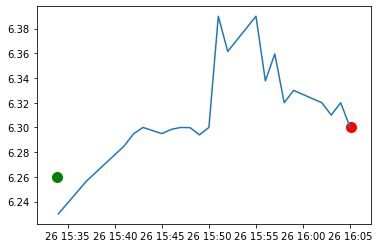

buy time:2020-02-26T15:33:49.076284724Z sell time:2020-02-26T16:05:07.431654139Z
{'rsi': 58.12768578133989, 'macd1': [0.01729142074002432, 0.01932816848438712, 0.023072877760062838, 0.02666120693319929, 0.0295516505083544], 'macd2': [0.03280476247277431, 0.03300983334658891, 0.033620720490636025, 0.03431291098903255, 0.034971638974980124], 'sell_macd': [0.00977820571553778, 0.01114794991051582, 0.013613361622050846, 0.015955067350232888, 0.017821915094916818], 'macd_signal': [0.008875649883739675, 0.010966153603869164, 0.013387498435107899, 0.016042240134726177, 0.018744122209451822], 'sell_macd_signal': [0.0037256568354092482, 0.005210115450430562, 0.006890764684754619, 0.008703625217850272, 0.01052728319326358]}
{'rsi': 50.722483777872675, 'macd': [0.020897745146141844, 0.018705170865627174, 0.016234266609828296, 0.01461753255842968, 0.012134135472164687], 'scalp': 0, 'bail_out': 0, 'movement': -0.01560937500000012, 'too_close': 1, 'macd_signal': [0.02284580728462015, 0.0220176800008

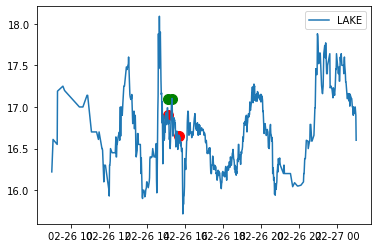

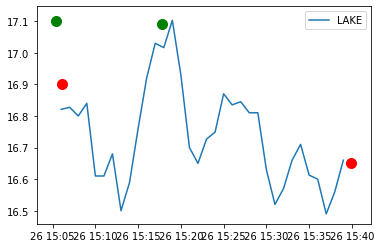

Delta = -0.6400000000000041


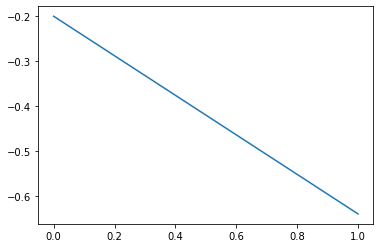

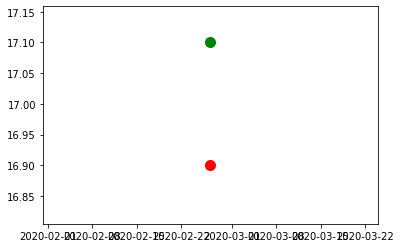

buy time:2020-02-26T15:05:26.759398408Z sell time:2020-02-26T15:06:09.26909392Z
{'rsi': 56.03906683069573, 'macd1': [0.033154218428048665, 0.027065741323017534, 0.030969461638758133, 0.0407268554856941, 0.059203140061089954], 'macd2': [0.22025833451911225, 0.21505047934240196, 0.21171602245356524, 0.20972343973024365, 0.20981947067575035], 'sell_macd': [0.005488667113745294, 0.0024698029432101976, 0.005934716538334328, 0.013149782761310291, 0.0259569800420536], 'macd_signal': [0.06701352413261559, 0.05902396757069598, 0.053413066384308414, 0.05087582420458555, 0.05254128737588643], 'sell_macd_signal': [0.024193404797841104, 0.019848684426914922, 0.017065890849198802, 0.0162826692316211, 0.0182175313937076]}
{'rsi': 48.81096080536905, 'macd': [0.0024698029432101976, 0.005934716538334328, 0.013149782761310291, 0.01868425276932939, 0.014442485856491771], 'scalp': 0, 'bail_out': 0, 'movement': -0.017513134851138396, 'too_close': 1, 'macd_signal': [0.019848684426914922, 0.017065890849198802

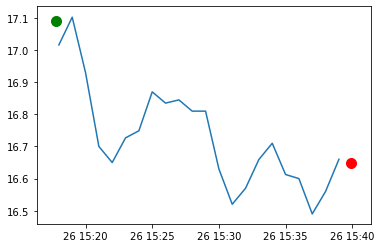

buy time:2020-02-26T15:17:48.867122556Z sell time:2020-02-26T15:39:56.334648212Z
{'rsi': 58.35590096301216, 'macd1': [-0.04176218437240209, -0.04955247151210074, -0.04149810990916336, -0.0219831757768425, 0.0071180766148799535], 'macd2': [0.1571598296660568, 0.15016122313232572, 0.14620742923922592, 0.14488855300372805, 0.14616232812172214], 'sell_macd': [-0.03446966184579381, -0.03882020023607069, -0.0328541236540012, -0.019487646789347224, 1.2044881671613439e-05], 'macd_signal': [0.0017601831987987485, -0.008502347743381149, -0.01510150017653759, -0.016477835296598572, -0.011758652914302867], 'sell_macd_signal': [-0.008914706130912213, -0.014895804951943908, -0.018487468692355367, -0.018687504311753738, -0.014947594473068667]}
{'rsi': 47.579166061945486, 'macd': [-0.030341663035660105, -0.03276845550901086, -0.03994818398812683, -0.041382411582400636, -0.03729242773920305], 'scalp': 0, 'bail_out': 1, 'movement': 0.004379456368308527, 'too_close': 0, 'macd_signal': [-0.019540047157849

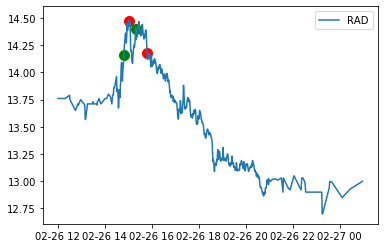

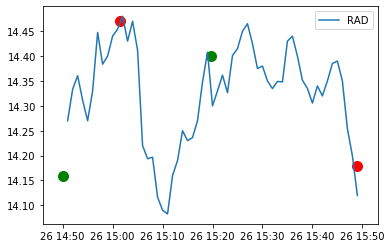

Delta = 0.08999999999999986


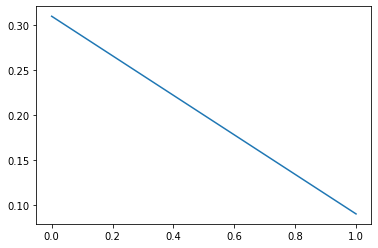

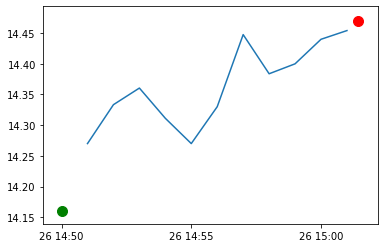

buy time:2020-02-26T14:50:01.738264957Z sell time:2020-02-26T15:01:24.763711844Z
{'rsi': 66.1207618879299, 'macd1': [0.12485049334909348, 0.1173614987567344, 0.11972127223842577, 0.12500005462734975, 0.13401334505026874], 'macd2': [0.04031038461132397, 0.04233054690485005, 0.046039091986731506, 0.05033865450790742, 0.05547737451718149], 'sell_macd': [0.07784902559925477, 0.07254320524821445, 0.07369525165976398, 0.0767579468939612, 0.0822515023115944], 'macd_signal': [0.09604074840214029, 0.10030489847305911, 0.10418817322613244, 0.1083505495063759, 0.11348310861515447], 'sell_macd_signal': [0.06052377751484568, 0.06292766306151944, 0.06508118078116834, 0.06741653400372691, 0.0703835276653004]}
{'rsi': 70.43404917836568, 'macd': [0.1048025213068744, 0.1032754833923093, 0.10158590211612406, 0.1010279699253811, 0.1013538932842124], 'scalp': 1, 'bail_out': 0, 'movement': 0.021221524790182692, 'too_close': 0, 'macd_signal': [0.09654649910339062, 0.09789229596117435, 0.0986310171921643, 0.0

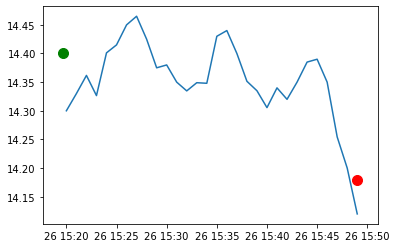

buy time:2020-02-26T15:19:38.724710407Z sell time:2020-02-26T15:49:01.515601144Z
{'rsi': 62.85408199599502, 'macd1': [0.015454202284951535, 0.015565596976452767, 0.018179759803395257, 0.026234961336717433, 0.03639519089887244], 'macd2': [0.09212922743016527, 0.09067598225040463, 0.08973610976434543, 0.0899737782851453, 0.09088020777463868], 'sell_macd': [0.0018199869138424418, 0.002343946120211271, 0.004482824123613227, 0.010138017059723836, 0.017114297048124172], 'macd_signal': [0.04449644604417115, 0.03871027623062747, 0.034604172945181026, 0.03293033062348831, 0.033623302678565135], 'sell_macd_signal': [0.019551350539023307, 0.0161098696552609, 0.013784460548931366, 0.01305517185108986, 0.013866996890496721]}
{'rsi': 35.322896652496965, 'macd': [0.005410888338980513, 0.004271635621043046, -0.0016378033230761702, -0.009047264794817877, -0.015742335230008564], 'scalp': 0, 'bail_out': 0, 'movement': -0.015277777777777822, 'too_close': 1, 'macd_signal': [0.008276330986855854, 0.00747539

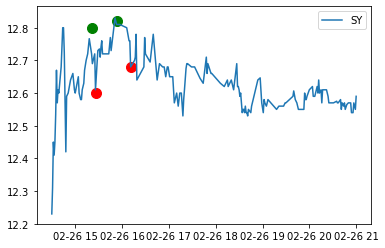

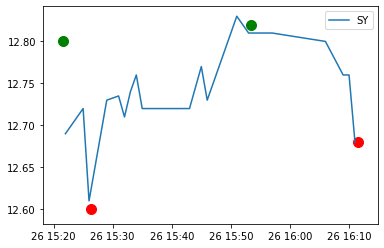

Delta = -0.34000000000000163


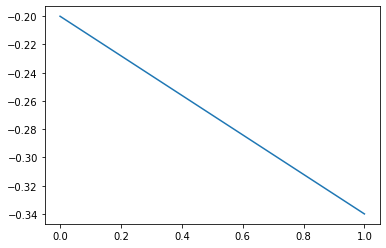

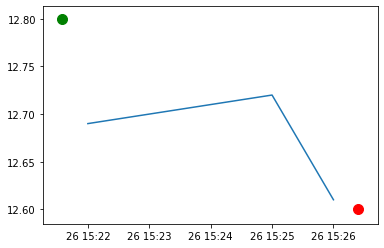

buy time:2020-02-26T15:21:34.927411872Z sell time:2020-02-26T15:26:23.999827557Z
{'rsi': 67.71434491286406, 'macd1': [0.0508932847133039, 0.05291381419669783, 0.055489285282586565, 0.06058414969138681, 0.06655779958783725], 'macd2': [0.057509628435147064, 0.058460201417329216, 0.05956113209558822, 0.06122246634680728, 0.06318881590564907], 'sell_macd': [0.027837549401279915, 0.029217372472185588, 0.03095207392390087, 0.03431739877038176, 0.03823430905633529], 'macd_signal': [0.058688994023919305, 0.05753395805847501, 0.057125023503297324, 0.05781684874091522, 0.05956503891029963], 'sell_macd_signal': [0.03300078618153578, 0.03224410343966574, 0.031985697536512765, 0.032452037783286564, 0.03360849203789631]}
{'rsi': 48.00110777312887, 'macd': [0.03431739877038176, 0.03407846490049238, 0.03189126363953143, 0.03133122027203683, 0.024254157644481467], 'scalp': 0, 'bail_out': 0, 'movement': -0.015625000000000083, 'too_close': 1, 'macd_signal': [0.032452037783286564, 0.03277732320672773, 0.0

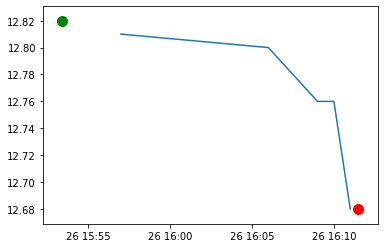

buy time:2020-02-26T15:53:23.854933599Z sell time:2020-02-26T16:11:27.344178746Z
{'rsi': 61.80128214140483, 'macd1': [0.039308174970392074, 0.036956977954902825, 0.04107547627091712, 0.04542956496556272, 0.04752545137913877], 'macd2': [0.06092650999458549, 0.06042194558331282, 0.061140581931704574, 0.0620238365938075, 0.06257732465103416], 'sell_macd': [0.02136403921291752, 0.01990956097001728, 0.02267347972918543, 0.025571682921663452, 0.026978442773962996], 'macd_signal': [0.042759096415725575, 0.04159867272356103, 0.04149403343303225, 0.04228113973953834, 0.04333000206745843], 'sell_macd_signal': [0.02332189615914541, 0.022639429121319783, 0.022646239242892913, 0.02323132797864702, 0.023980750937710217]}
{'rsi': 44.872042796390375, 'macd': [0.026806725861169056, 0.02621009067337532, 0.023326867271544316, 0.020777253357501024, 0.014364862601654593], 'scalp': 0, 'bail_out': 0, 'movement': -0.010920436817472743, 'too_close': 1, 'macd_signal': [0.024462829039285337, 0.024812281366103334

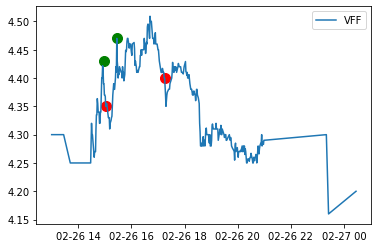

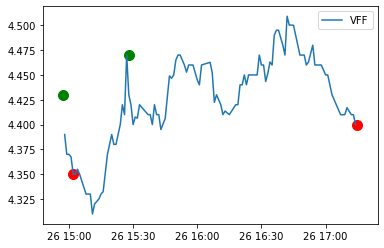

Delta = -0.14999999999999947


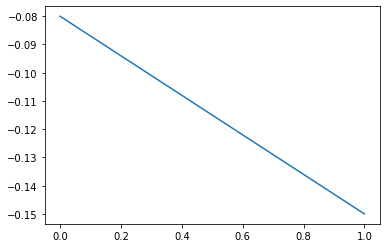

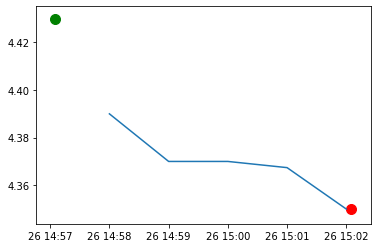

buy time:2020-02-26T14:57:05.304029914Z sell time:2020-02-26T15:02:04.841374822Z
{'rsi': 71.76521020210386, 'macd1': [0.031069910590770355, 0.033885490776525806, 0.03743632436050426, 0.039424740138716, 0.04156239078958013], 'macd2': [0.01436815691411919, 0.015722380007712644, 0.017290223997447285, 0.018631466750102632, 0.020041972030733213], 'sell_macd': [0.018871450615288055, 0.02062353173712328, 0.022848224406901707, 0.02404605993651021, 0.02533728164871718], 'macd_signal': [0.02797868222538095, 0.029160043935609923, 0.03081530002058879, 0.03253718804421423, 0.03434222859328741], 'sell_macd_signal': [0.017222936289226037, 0.017903055378805485, 0.01889208918442473, 0.019922883334841827, 0.021005762997616896]}
{'rsi': 54.00427243905168, 'macd': [0.022344276693994303, 0.020302078651110556, 0.01844709214170681, 0.01662701054812299, 0.01459802475379579], 'scalp': 0, 'bail_out': 0, 'movement': -0.01584650112866813, 'too_close': 1, 'macd_signal': [0.020940998204424945, 0.020813214293762067,

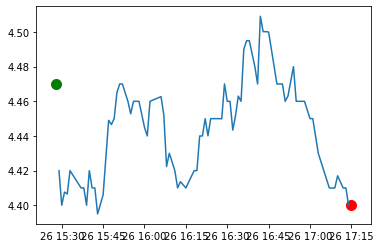

buy time:2020-02-26T15:28:01.728522628Z sell time:2020-02-26T17:14:52.120740536Z
{'rsi': 74.97056064389626, 'macd1': [0.012993696612165095, 0.016254282917464558, 0.01782591853651816, 0.023640437400032077, 0.027926565428141537], 'macd2': [0.017089693522638782, 0.017796517095775677, 0.018258418324646364, 0.019613796595071342, 0.020829418431883795], 'sell_macd': [0.007364208044993603, 0.009508195696128041, 0.01053587184381577, 0.014316712064821324, 0.01707689000242496], 'macd_signal': [0.008476458905973634, 0.010032023708271819, 0.011590802673921086, 0.014000729619143285, 0.016785896780942937], 'sell_macd_signal': [0.004192223240866688, 0.005255417731918959, 0.006311508554298321, 0.007912549256402921, 0.009745417405607328]}
{'rsi': 29.66835478663064, 'macd': [-0.009365354674899962, -0.009527660586086562, -0.009894033236542477, -0.010051024480579152, -0.010562303054106437], 'scalp': 0, 'bail_out': 0, 'movement': -0.01565995525727056, 'too_close': 0, 'macd_signal': [-0.004760635119693953, -

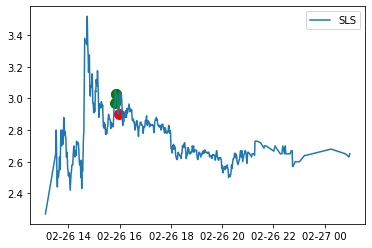

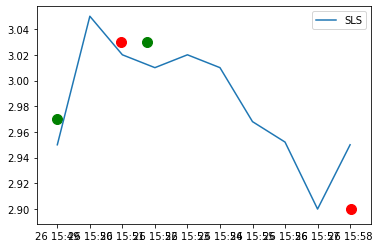

Delta = -0.07000000000000028


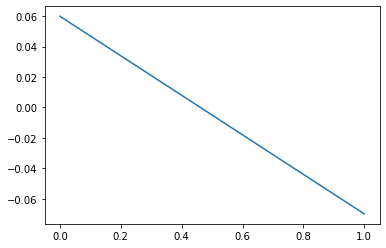

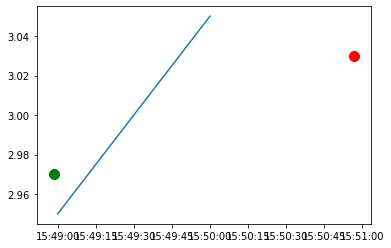

buy time:2020-02-26T15:48:58.680139231Z sell time:2020-02-26T15:50:56.57385482Z
{'rsi': 62.43633878026708, 'macd1': [-0.017974488244364206, -0.017514597028558843, -0.0121683620642834, -0.003054720857921911, 0.0057158495556994815], 'macd2': [0.03514626855662906, 0.03351562184620116, 0.03292138731278271, 0.03328163552923735, 0.03387971813777213], 'sell_macd': [-0.010760028384765974, -0.01040445043037419, -0.006875370849934281, -0.0009192650619298526, 0.004772755877579193], 'macd_signal': [-0.020127193592316392, -0.01960467427956488, -0.018117411836508585, -0.01510487364079125, -0.010940729001493104], 'sell_macd_signal': [-0.01269195530269409, -0.01223445432823011, -0.011162637632570945, -0.009113963118442727, -0.006336619319238342]}
{'rsi': 66.55237480266088, 'macd': [-0.006875370849934281, -0.0009192650619298526, 0.004772755877579193, 0.008107151987877259, 0.014761133996059606], 'scalp': 1, 'bail_out': 0, 'movement': 0.020235690235690173, 'too_close': 0, 'macd_signal': [-0.0111626376325

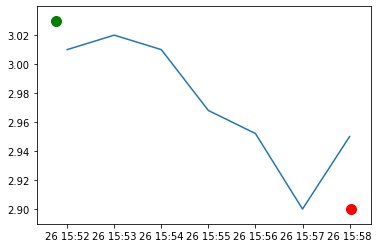

buy time:2020-02-26T15:51:46.304843755Z sell time:2020-02-26T15:58:02.142660243Z
{'rsi': 66.5449286882599, 'macd1': [-0.0121683620642834, -0.003054720857921911, 0.0057158495556994815, 0.010926799599924486, 0.021266697217480868], 'macd2': [0.03292138731278271, 0.03328163552923735, 0.03387971813777213, 0.034055915342765086, 0.03544304293465528], 'sell_macd': [-0.006875370849934281, -0.0009192650619298526, 0.004772755877579193, 0.008107151987877259, 0.014755939190864709], 'macd_signal': [-0.018117411836508585, -0.01510487364079125, -0.010940729001493104, -0.006567223281209586, -0.0010004391814714946], 'sell_macd_signal': [-0.011162637632570945, -0.009113963118442727, -0.006336619319238342, -0.003447865057815222, 0.00019289579192076443]}
{'rsi': 46.53237726267206, 'macd': [0.025584610524607143, 0.023742801637584687, 0.02117330378227411, 0.01618962618356079, 0.012095986156205552], 'scalp': 0, 'bail_out': 0, 'movement': -0.042904290429042875, 'too_close': 1, 'macd_signal': [0.014171373531273

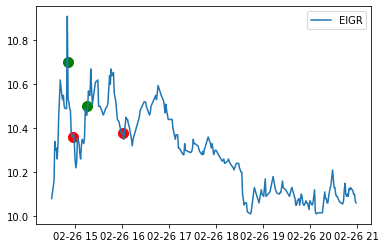

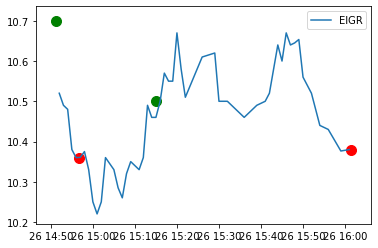

Delta = -0.4599999999999991


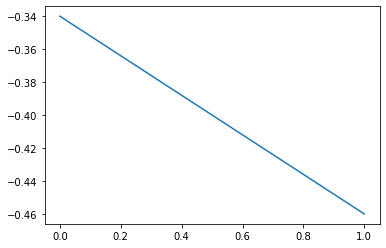

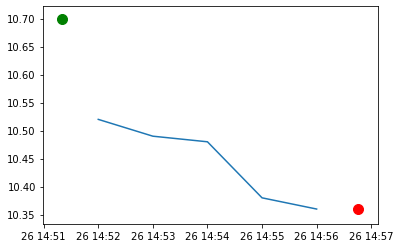

buy time:2020-02-26T14:51:19.727512432Z sell time:2020-02-26T14:56:45.63803615Z
{'rsi': 69.27174903000193, 'macd1': [0.16151430010678247, 0.15600917113740742, 0.1499181536128269, 0.17694179340282368, 0.18333419730207723], 'macd2': [0.06330246582204246, 0.06659482077165713, 0.06951738352894488, 0.07881236448472428, 0.08467901851163795], 'sell_macd': [0.09880726675081952, 0.09475520888370248, 0.09036717406667982, 0.10759250831229039, 0.11130585307104823], 'macd_signal': [0.14358321783696795, 0.14606840849705585, 0.14683835752021007, 0.15285904469673278, 0.15895407521780167], 'sell_macd_signal': [0.08905342337187018, 0.09019378047423664, 0.09022845919272528, 0.0937012690166383, 0.09722218582752029]}
{'rsi': 49.66411578512766, 'macd': [0.09204882863167896, 0.0831948544851926, 0.07469572067643426, 0.0619081395179677, 0.05010082771243596], 'scalp': 0, 'bail_out': 0, 'movement': -0.015209125475285185, 'too_close': 1, 'macd_signal': [0.09435894295978044, 0.09212612526486287, 0.0886400443471771

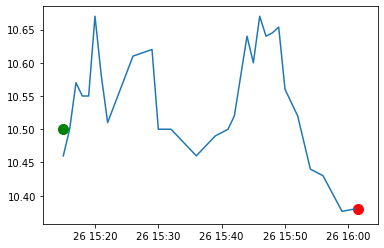

buy time:2020-02-26T15:14:55.400469846Z sell time:2020-02-26T16:01:26.852245711Z
{'rsi': 60.17012783705829, 'macd1': [-0.004426038847379132, -0.004030123634962024, -0.0012808439256879467, 0.011258117030873649, 0.021751512458026312], 'macd2': [0.0581853144591058, 0.056865353251383866, 0.056039806609250675, 0.05726981778478546, 0.058469808366059084], 'sell_macd': [-0.008409769339838391, -0.007746418159152668, -0.005570476743564257, 0.002950652628888051, 0.010071654053801282], 'macd_signal': [0.013097894595444921, 0.009672290949363532, 0.0074816639743532365, 0.008236954585657319, 0.010939866160131118], 'sell_macd_signal': [0.0016221951607367415, -0.00025152750324114047, -0.0013153173513057639, -0.00046212335526700087, 0.001644632126546656]}
{'rsi': 34.32554725393581, 'macd': [0.01321202887712758, 0.005740269323734282, -0.0006759104493490042, -0.008451168578382351, -0.0168104454506377], 'scalp': 0, 'bail_out': 0, 'movement': -0.016190476190476182, 'too_close': 1, 'macd_signal': [0.02087225

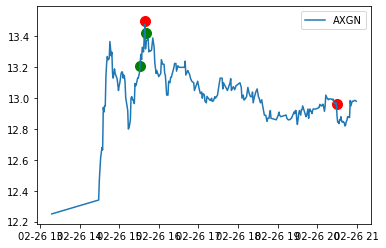

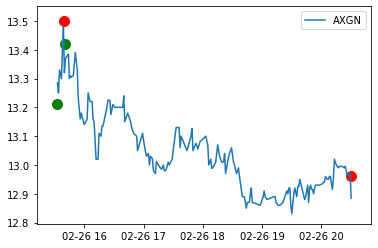

Delta = -0.16999999999999993


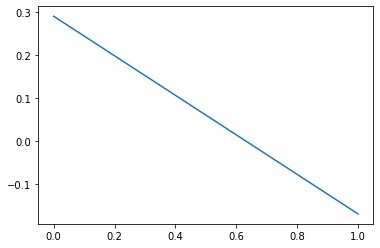

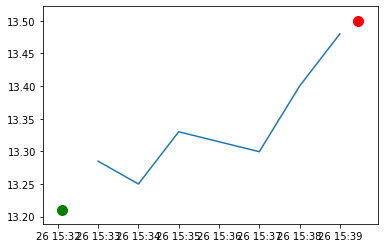

buy time:2020-02-26T15:32:06.302157223Z sell time:2020-02-26T15:39:26.627755575Z
{'rsi': 68.31585622309176, 'macd1': [0.0240948661239635, 0.030006127420390882, 0.03589094892134703, 0.04168799198994577, 0.050541082804489434], 'macd2': [0.08379692933407057, 0.08376349508862013, 0.0839186385595756, 0.08424703143139922, 0.08537403817763867], 'sell_macd': [0.011408080345134408, 0.015503404194486592, 0.019532183762883903, 0.023456788832247, 0.029327172148216007], 'macd_signal': [0.009926235317718732, 0.013942213738253162, 0.018331960774871935, 0.023003167017886704, 0.02851075017520725], 'sell_macd_signal': [0.000428919767294195, 0.0034438166527326745, 0.006661490074762921, 0.010020549826259736, 0.01388187429065099]}
{'rsi': 76.7154892426218, 'macd': [0.03987936507772183, 0.045935649371157794, 0.04847384947810518, 0.055042916451334634, 0.06464163206097773], 'scalp': 1, 'bail_out': 0, 'movement': 0.02040816326530609, 'too_close': 0, 'macd_signal': [0.02281089579869697, 0.027435846513189137, 0.

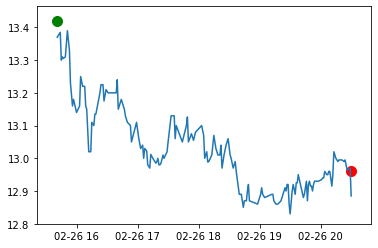

buy time:2020-02-26T15:40:24.377982268Z sell time:2020-02-26T20:30:04.959857793Z
{'rsi': 74.80853291802404, 'macd1': [0.07605258714101559, 0.08009190426834678, 0.09036097718271208, 0.10375855878590201, 0.1122750850130636], 'macd2': [0.09021770783637173, 0.09141698395772835, 0.09398150471719013, 0.09747012376903008, 0.10036393902021246], 'sell_macd': [0.045935649371157794, 0.04847384947810518, 0.055042916451334634, 0.06360267102201611, 0.06892712041446991], 'macd_signal': [0.04848314958060153, 0.05480490051815058, 0.06191611585106288, 0.07028460443803071, 0.07868270055303729], 'sell_macd_signal': [0.027435846513189137, 0.03164344710617235, 0.0363233409752048, 0.041779206984567066, 0.04720878967054763]}
{'rsi': 49.588701091304685, 'macd': [0.010380581576880488, 0.008479906792292269, 0.006888732845959922, 0.0058191332404273766, 0.004650365583643179], 'scalp': 0, 'bail_out': 1, 'movement': 0.005818463925523606, 'too_close': 1, 'macd_signal': [0.011557353394896813, 0.010941864074375904, 0.0

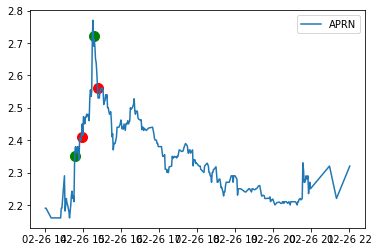

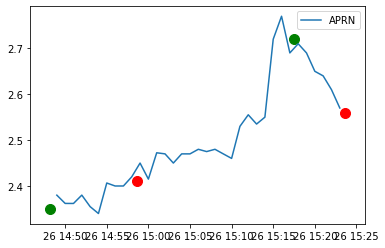

Delta = -0.10000000000000009


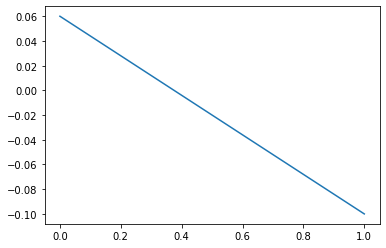

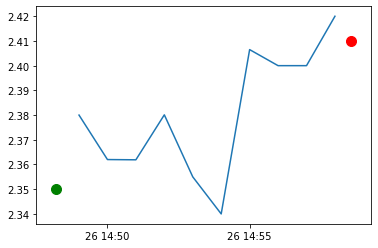

buy time:2020-02-26T14:48:11.173850329Z sell time:2020-02-26T14:58:34.671335607Z
{'rsi': 69.92408822491763, 'macd1': [0.03256171377072237, 0.03281054241762815, 0.03324582933565834, 0.04162395066077407, 0.050649271349559655], 'macd2': [0.009233644175357547, 0.010210615305137338, 0.01121628028250754, 0.013810910427169087, 0.01676452910815973], 'sell_macd': [0.020721034951873385, 0.020745726256686137, 0.02089554121814219, 0.02622142896449553, 0.03194262163743966], 'macd_signal': [0.02333474622959444, 0.025229905467201184, 0.026833090240892615, 0.029791262324868905, 0.033962864129807056], 'sell_macd_signal': [0.015120294843261946, 0.016245381125946784, 0.017175413144385865, 0.0189846163084078, 0.021576217374214172]}
{'rsi': 68.58319038684967, 'macd': [0.038472637524909814, 0.03990212520816616, 0.040160139958649754, 0.039839630154368866, 0.03999196498019719], 'scalp': 1, 'bail_out': 0, 'movement': 0.02012658227848095, 'too_close': 0, 'macd_signal': [0.03481476687045272, 0.03583223853799541,

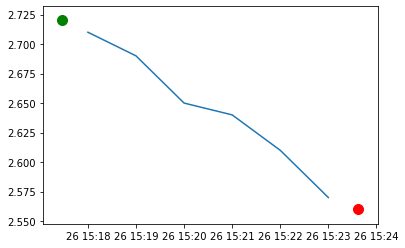

buy time:2020-02-26T15:17:27.83089758Z sell time:2020-02-26T15:23:37.118654707Z
{'rsi': 74.8343099471362, 'macd1': [0.06029319998019833, 0.06080999153575517, 0.07408314740935928, 0.08762669520310196, 0.09325053811611284], 'macd2': [0.05382484295588874, 0.05485761989299354, 0.058438983048813675, 0.062440166851031265, 0.0652218394865769], 'sell_macd': [0.03473399351804085, 0.03504162857797555, 0.04365742695483421, 0.05240145910621985, 0.0559370496254008], 'macd_signal': [0.0608471350272243, 0.060839706328930473, 0.06348839454501623, 0.06831605467663338, 0.07330295136452927], 'sell_macd_signal': [0.03534425242364473, 0.03528372765451089, 0.03695846751457556, 0.04004706583290442, 0.0432250625914037]}
{'rsi': 51.70104824121097, 'macd': [0.055945242426589825, 0.052898633839916887, 0.04931817735887378, 0.04432927390145247, 0.037268709208637674], 'scalp': 0, 'bail_out': 0, 'movement': -0.019194666871001125, 'too_close': 1, 'macd_signal': [0.04765522806431439, 0.04870390921943489, 0.04882676284

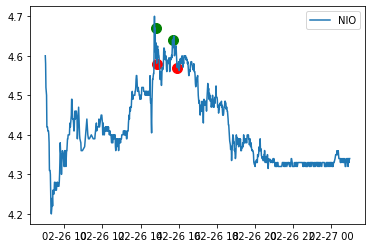

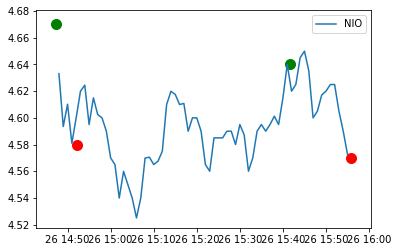

Delta = -0.15999999999999925


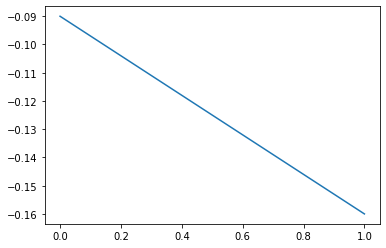

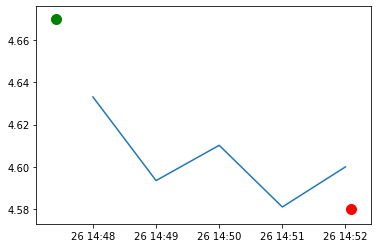

buy time:2020-02-26T14:47:24.731475024Z sell time:2020-02-26T14:52:05.452865391Z
{'rsi': 65.44736696446266, 'macd1': [0.0459605291286973, 0.05626547392656356, 0.05657429992003049, 0.06090202057109462, 0.06399750517724279], 'macd2': [0.01887347547156537, 0.022125744757192756, 0.023654320785660765, 0.025971248477929088, 0.028141326697039837], 'sell_macd': [0.028554654803085278, 0.03512147664208243, 0.03514339656023591, 0.03778458874892365, 0.03961169189921332], 'macd_signal': [0.03372418332358476, 0.03823244144418052, 0.04190081313935051, 0.04570105462569933, 0.04936034473600802], 'sell_macd_signal': [0.020997650435558745, 0.02382241567686348, 0.026086611853537965, 0.028426207232615103, 0.030663304165934747]}
{'rsi': 51.83833337671434, 'macd': [0.03615510837384672, 0.033161322030116125, 0.03126536745019415, 0.027865073395057394, 0.024801661489820326], 'scalp': 0, 'bail_out': 0, 'movement': -0.02032085561497321, 'too_close': 1, 'macd_signal': [0.03130452215037431, 0.03167588212632268, 0.0

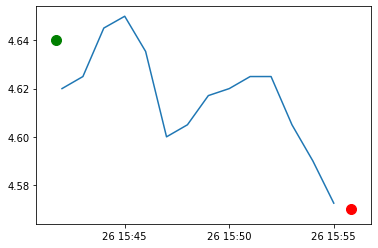

buy time:2020-02-26T15:41:43.151897385Z sell time:2020-02-26T15:55:50.580863078Z
{'rsi': 65.32303975899113, 'macd1': [0.0024295350919496528, 0.0034138708818689523, 0.003651582730018532, 0.00539165232352623, 0.008687813374581133], 'macd2': [0.01511657919137921, 0.01500033982874438, 0.014770244613734107, 0.014854798764796229, 0.01530867317764617], 'sell_macd': [0.0011009968384252389, 0.0017670465436960825, 0.0019410197355478331, 0.0030903362521135236, 0.005244474625383688], 'macd_signal': [0.0020823828215463637, 0.0023486804336108813, 0.0026092608928924114, 0.0031657391790191752, 0.0042701540181315665], 'sell_macd_signal': [0.0007262678940014686, 0.0009344236239403914, 0.0011357428462618797, 0.0015266615274322085, 0.0022702241470225044]}
{'rsi': 39.19237511270645, 'macd': [0.005382944553188551, 0.005291340539022471, 0.004112281040463905, 0.0023609063527496588, -7.342335654403342e-05], 'scalp': 0, 'bail_out': 0, 'movement': -0.015086206896551595, 'too_close': 1, 'macd_signal': [0.00594726

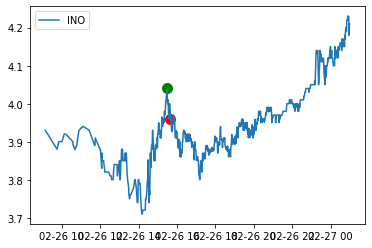

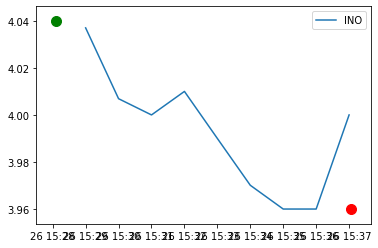

Delta = -0.08000000000000007


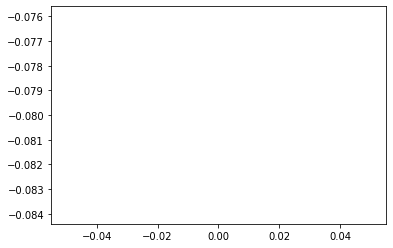

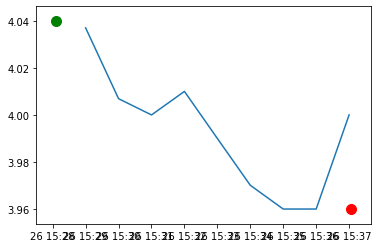

buy time:2020-02-26T15:28:05.996504903Z sell time:2020-02-26T15:37:03.747127115Z
{'rsi': 74.46403694213535, 'macd1': [0.022149703976819257, 0.02419349322704356, 0.02572645069400492, 0.027535731322604562, 0.030131199264412434], 'macd2': [0.027907325838183894, 0.028437639306871265, 0.028921645997883605, 0.02950141921340821, 0.030286726087486393], 'sell_macd': [0.012597038563190388, 0.013936174598222717, 0.014933732877491668, 0.016104119421370466, 0.01777839309943996], 'macd_signal': [0.021184956997608462, 0.02178666424349548, 0.02257462153359737, 0.023566843491398808, 0.024879714646001534], 'sell_macd_signal': [0.011900510457766359, 0.012307643285857631, 0.012832861204184438, 0.013487112847621644, 0.014345368897985307]}
{'rsi': 49.48933089358105, 'macd': [0.013390756469275011, 0.01076781304012897, 0.008059443964948176, 0.005844358400327376, 0.004556702656462797], 'scalp': 0, 'bail_out': 0, 'movement': -0.017351485148514863, 'too_close': 0, 'macd_signal': [0.015090875442599638, 0.01422626

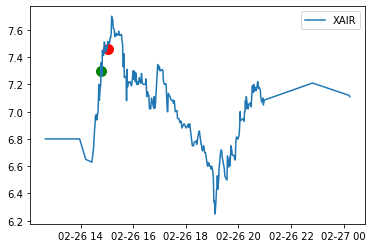

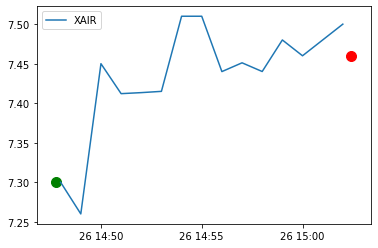

Delta = 0.16000000000000014


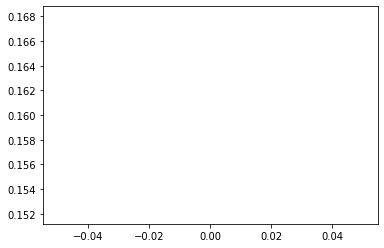

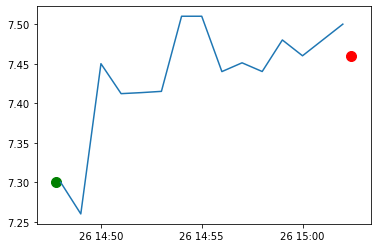

buy time:2020-02-26T14:47:47.461006762Z sell time:2020-02-26T15:02:25.454423278Z
{'rsi': 70.10700923742297, 'macd1': [0.05386838424715901, 0.07347687877059883, 0.07870886873887173, 0.08950534100758833, 0.11140678975364704], 'macd2': [-0.006184820231919019, -0.00024796562695783564, 0.003351272401239669, 0.008179917588475583, 0.015508983124451703], 'sell_macd': [0.0362398097609864, 0.04871929456567603, 0.051758902276269225, 0.0584006887744426, 0.07223583813958534], 'macd_signal': [0.011866818297919983, 0.024188830392455753, 0.03509283806173895, 0.045975338650908824, 0.05906162887145647], 'sell_macd_signal': [0.009077602401726937, 0.01700594083451676, 0.023956533122867253, 0.030845364253182322, 0.03912345903046292]}
{'rsi': 63.95653640764108, 'macd': [0.09515052648571753, 0.09244166907431062, 0.08809136889562552, 0.08459644188761661, 0.07976148003867856], 'scalp': 0, 'bail_out': 0, 'movement': -0.015648295971817328, 'too_close': 1, 'macd_signal': [0.09379732556904274, 0.09352619427009631,

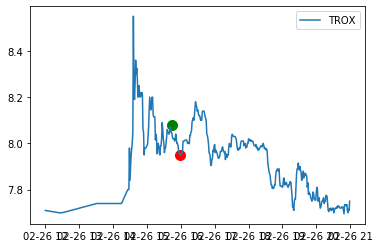

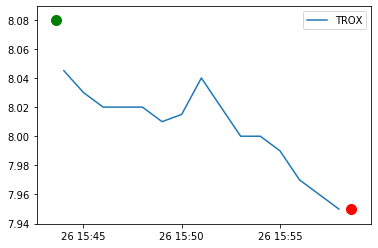

Delta = -0.1299999999999999


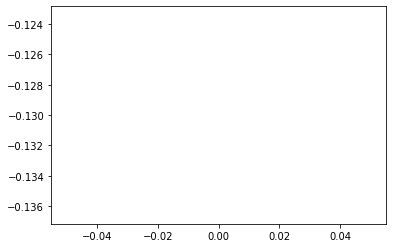

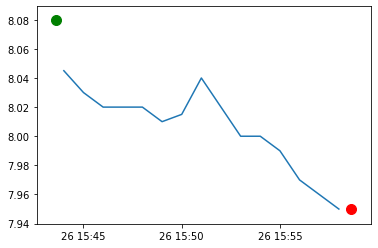

buy time:2020-02-26T15:43:37.011704683Z sell time:2020-02-26T15:58:38.409313966Z
{'rsi': 57.34708806676563, 'macd1': [-0.002974295247916814, -0.0008717945949907602, 0.002380840327900202, 0.004902068938964277, 0.007619247264566198], 'macd2': [0.022383405061347617, 0.022015491577407786, 0.021961660752596757, 0.021877010064510927, 0.02192407552890785], 'sell_macd': [-0.0014288744601707037, -5.0054820393441446e-05, 0.0020639611952830705, 0.003684441711456543, 0.005418784429103596], 'macd_signal': [-0.010559666192997594, -0.008622091873396227, -0.0064215054331369405, -0.004156790558716697, -0.0018015829940601176], 'sell_macd_signal': [-0.006733390415655391, -0.005396723296603001, -0.0039045863982257864, -0.0023867807762893204, -0.0008256677352107369]}
{'rsi': 34.031819263139845, 'macd': [-0.0029691982652870763, -0.003935309755350502, -0.005156496504032049, -0.007080064145808862, -0.009525960176468118], 'scalp': 0, 'bail_out': 0, 'movement': -0.016089108910891076, 'too_close': 1, 'macd_signa

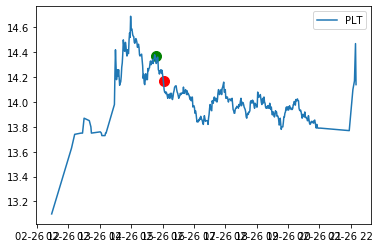

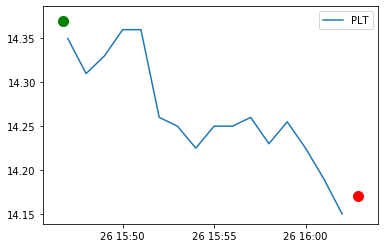

Delta = -0.1999999999999993


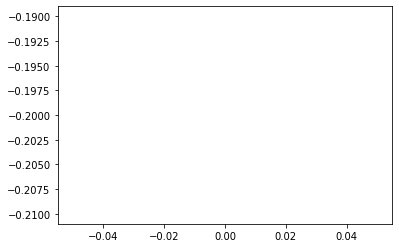

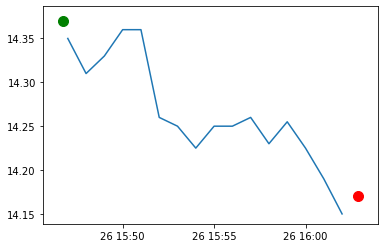

buy time:2020-02-26T15:46:42.787868249Z sell time:2020-02-26T16:02:51.389670311Z
{'rsi': 60.01014656782574, 'macd1': [-0.006117499219916667, -0.004446439928361912, 0.0001043494303019088, 0.0060617559143789634, 0.011856740984077518], 'macd2': [0.04021389984549728, 0.03908017655502327, 0.0386143556843308, 0.038603835393965724, 0.03877231898864508], 'sell_macd': [-0.0028039473173997465, -0.0016987329379372085, 0.001262456616681007, 0.00511192306681707, 0.008824339481639853], 'macd_signal': [-0.023622677014394106, -0.019787429597187666, -0.015809073791689752, -0.011434907850476008, -0.006776578083565302], 'sell_macd_signal': [-0.015021641810899692, -0.012357060036307195, -0.009633156705709554, -0.006684140751204229, -0.0035824447046354123]}
{'rsi': 36.464835058812206, 'macd': [-0.011107645300349134, -0.011152505466027307, -0.012601065264398414, -0.015384344779176828, -0.017924765897456396], 'scalp': 0, 'bail_out': 0, 'movement': -0.015005210142410512, 'too_close': 1, 'macd_signal': [-0.004

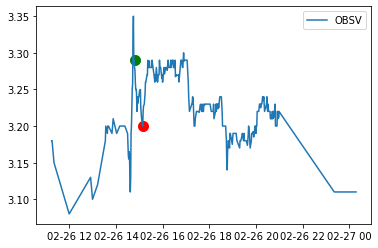

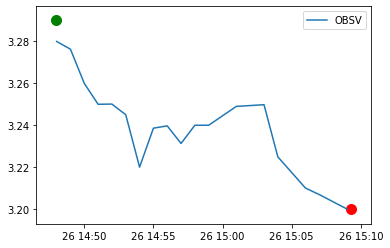

Delta = -0.08999999999999986


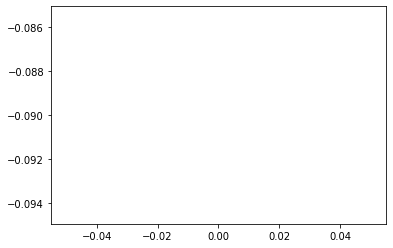

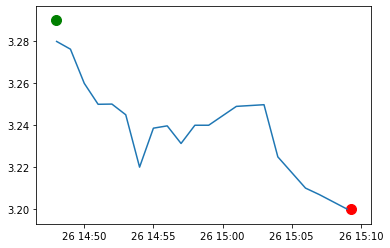

buy time:2020-02-26T14:47:59.223192474Z sell time:2020-02-26T15:09:18.284360383Z
{'rsi': 63.325870470773204, 'macd1': [0.028415164631091727, 0.033970020394396894, 0.04248200117311818, 0.051458829405186535, 0.05311920674478232], 'macd2': [0.007228224444786324, 0.009177463658961216, 0.01186778336195271, 0.014883758773042377, 0.01667513197809045], 'sell_macd': [0.018022918422381018, 0.021532419952785986, 0.02694849361345497, 0.032637012133282184, 0.033528883549598376], 'macd_signal': [0.017703732942863724, 0.02095699043317036, 0.025261992581159923, 0.030501359945965246, 0.03502492930572866], 'sell_macd_signal': [0.011311653748347819, 0.013355806989235452, 0.016074344314079357, 0.01938687787791992, 0.02221527901225561]}
{'rsi': 43.135402101675, 'macd': [0.01082808503189625, 0.008946804370577155, 0.0065906531491521925, 0.004508059299351608, 0.0024682711138006574], 'scalp': 0, 'bail_out': 0, 'movement': -0.01538461538461533, 'too_close': 1, 'macd_signal': [0.015333431472285488, 0.01405610605

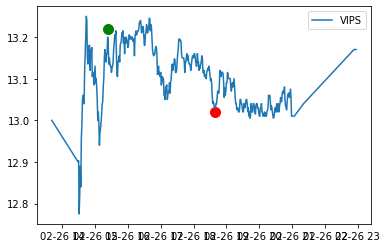

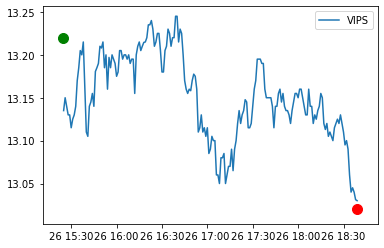

Delta = -0.20000000000000107


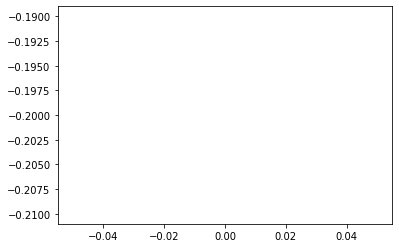

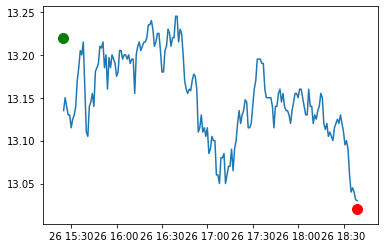

buy time:2020-02-26T15:24:29.812704256Z sell time:2020-02-26T18:39:14.970121449Z
{'rsi': 68.40738837707569, 'macd1': [0.022065660886807947, 0.025520936298436325, 0.027937224027793306, 0.03270283721714229, 0.03765933943424393], 'macd2': [0.03569177217444697, 0.036247335131507796, 0.03670049827572086, 0.03769846964786261, 0.03887621384966522], 'sell_macd': [0.013016714365015503, 0.015291108789178054, 0.01686477835619904, 0.019949913364836647, 0.023133785925271155], 'macd_signal': [0.007052726270404288, 0.010746368276010696, 0.014184539426367219, 0.017888198984522232, 0.021842427074466573], 'sell_macd_signal': [0.002598446434505375, 0.005136978905439911, 0.007482538795591737, 0.009976013709440719, 0.012607568152606805]}
{'rsi': 24.460435922279895, 'macd': [-0.010215100750409434, -0.011840562440792013, -0.013213122687313117, -0.014568194013339308, -0.016016714604873528], 'scalp': 0, 'bail_out': 0, 'movement': -0.015128593040847281, 'too_close': 1, 'macd_signal': [-0.006035069674085344, -0.

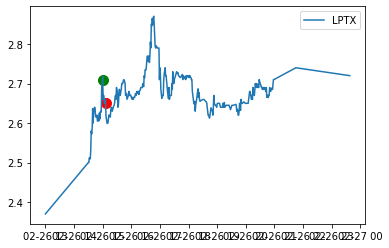

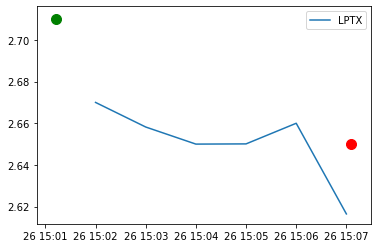

Delta = -0.06000000000000005


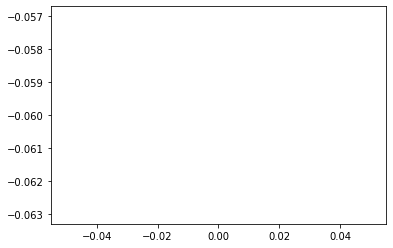

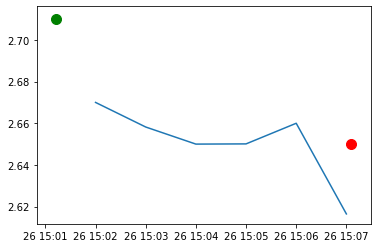

buy time:2020-02-26T15:01:12.599620457Z sell time:2020-02-26T15:07:05.910649136Z
{'rsi': 74.20552900780065, 'macd1': [0.03322998164246016, 0.036897265344863595, 0.040004142714610946, 0.0433943840417399, 0.045093355063943186], 'macd2': [0.02258542287595766, 0.024038834357441807, 0.02546872019569202, 0.027026614011378403, 0.028323937967335677], 'sell_macd': [0.01911244393336009, 0.021468331194475443, 0.023451252031779557, 0.0256113039565391, 0.02666054826211095], 'macd_signal': [0.0383643332962947, 0.038070919706008476, 0.03845756430772897, 0.03944492825453115, 0.040574613616413555], 'sell_macd_signal': [0.02285151177005154, 0.02257487565493632, 0.02275015093030497, 0.023322381535551794, 0.023990014880863626]}
{'rsi': 56.18680516377902, 'macd': [0.02111719067356832, 0.01905029991082996, 0.017197523992971142, 0.01604474374538034, 0.014418619607706962], 'scalp': 0, 'bail_out': 0, 'movement': -0.022897385789609544, 'too_close': 1, 'macd_signal': [0.022889989392225515, 0.022122051495946406, 

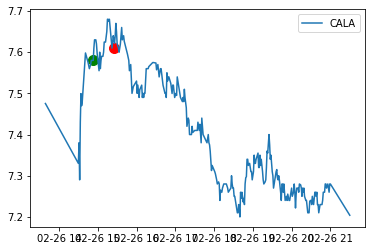

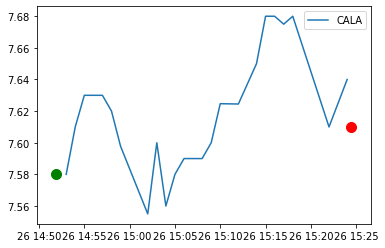

Delta = 0.03000000000000025


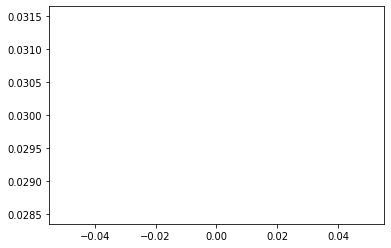

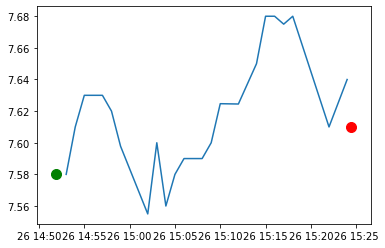

buy time:2020-02-26T14:51:55.315982863Z sell time:2020-02-26T15:24:27.585308722Z
{'rsi': 66.25707287307968, 'macd1': [0.06209694537810151, 0.07009162424543014, 0.07435991538940101, 0.0776543324920631, 0.08014819965235898], 'macd2': [0.01437174024337029, 0.017806215608001885, 0.020697660210794666, 0.02348471474505409, 0.02617126957286331], 'sell_macd': [0.03976673674721187, 0.04472367771123764, 0.047226181349294016, 0.049082337673112875, 0.05041074081280161], 'macd_signal': [0.03404737541544991, 0.041256225181445956, 0.047876963223036965, 0.053832437076842196, 0.05909558959194555], 'sell_macd_signal': [0.02199588947142555, 0.026541447119387968, 0.03067839396536918, 0.034359182706917915, 0.03756949432809466]}
{'rsi': 54.016795823161075, 'macd': [0.030649249736655726, 0.03067314686591338, 0.030553155708634705, 0.02642649823921417, 0.022867719714481538], 'scalp': 0, 'bail_out': 1, 'movement': 0.003957783641160982, 'too_close': 1, 'macd_signal': [0.03139873080271371, 0.03125361401535364, 0.

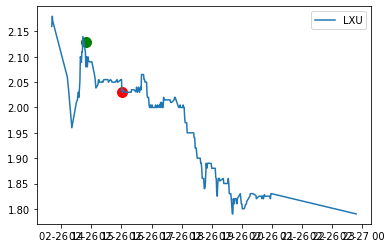

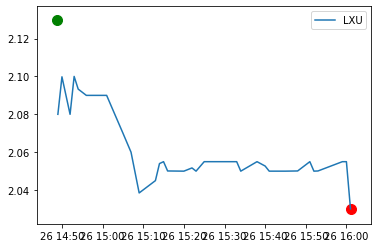

Delta = -0.10000000000000009


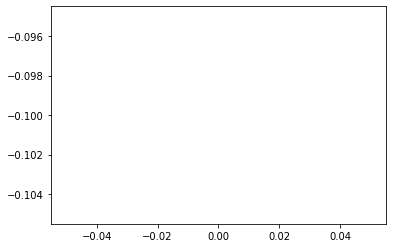

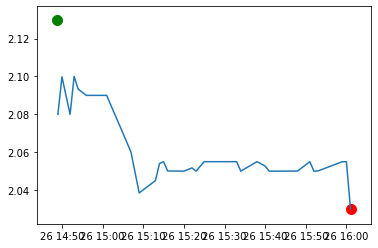

buy time:2020-02-26T14:48:41.053849014Z sell time:2020-02-26T16:01:11.342321763Z
{'rsi': 65.08354362622723, 'macd1': [0.033276195651531504, 0.03822034824211751, 0.04165043533454682, 0.04626431627209637, 0.0493359971630869], 'macd2': [0.008411751696118852, 0.010383272993848225, 0.012178929696807117, 0.014292920242477303, 0.016211800916054786], 'sell_macd': [0.021181335101987386, 0.02428215413963475, 0.026377829310014533, 0.029231890101089508, 0.031065809027886804], 'macd_signal': [0.01727964455436258, 0.021467785291913566, 0.025504315300440217, 0.02965631549477145, 0.03359225182843454], 'sell_macd_signal': [0.01090882348178894, 0.013583489613358101, 0.016142357552689387, 0.01876026406236941, 0.02122137305547289]}
{'rsi': 36.02546269511507, 'macd': [-0.0006209023871450725, -0.0006897757132162674, -0.00047993965933379457, -0.00031019806332999167, -0.0014674098318558926], 'scalp': 0, 'bail_out': 0, 'movement': -0.014514563106796134, 'too_close': 1, 'macd_signal': [-0.00013951259545345442, 

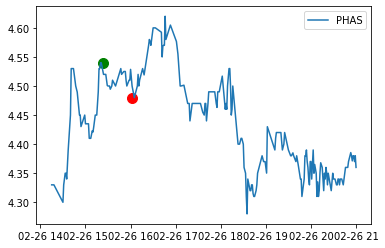

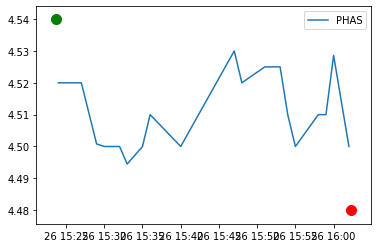

Delta = -0.05999999999999961


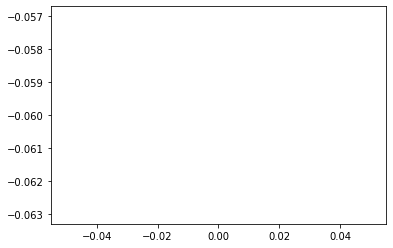

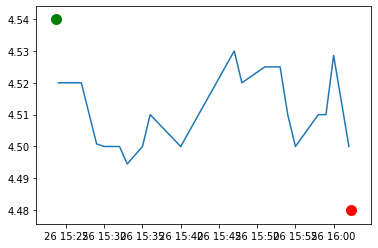

buy time:2020-02-26T15:23:44.618908942Z sell time:2020-02-26T16:02:17.573383997Z
{'rsi': 72.01222225369438, 'macd1': [0.015136653442580972, 0.020980423449765695, 0.025319782589870776, 0.029228741658728907, 0.03195822535474413], 'macd2': [-0.0004464663619261344, 0.001327681023755467, 0.0029578299283370413, 0.0046128244544174635, 0.006128094788961036], 'sell_macd': [0.009160787111325064, 0.01292537342231892, 0.01569095530851783, 0.018161656059990428, 0.01985101176165749], 'macd_signal': [0.013810070234006171, 0.015244140877158075, 0.017259269219700616, 0.019653163707506274, 0.022114176036953846], 'sell_macd_signal': [0.008553303060947294, 0.00942771713322162, 0.010680364768280862, 0.012176623026622774, 0.013711500773629717]}
{'rsi': 43.29120499206841, 'macd': [0.008888427141432231, 0.008124647636073234, 0.007423979870389452, 0.007747823431279777, 0.0048553921354628216], 'scalp': 0, 'bail_out': 0, 'movement': -0.015418502202643234, 'too_close': 1, 'macd_signal': [0.011514793161699169, 0.0

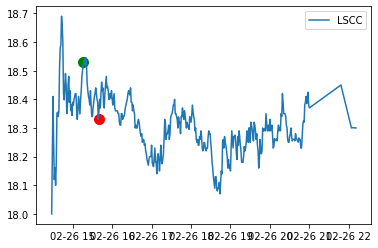

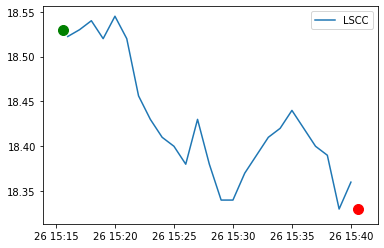

Delta = -0.20000000000000284


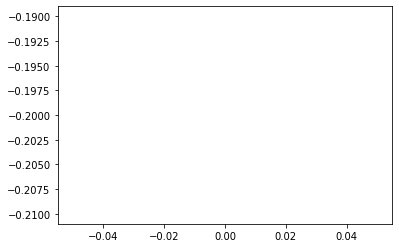

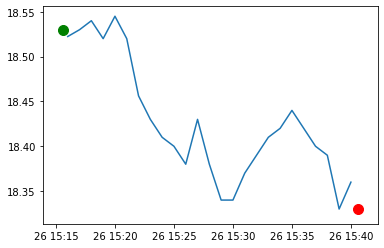

buy time:2020-02-26T15:15:34.244499406Z sell time:2020-02-26T15:40:33.942329585Z
{'rsi': 62.42719242576437, 'macd1': [0.01255202990158466, 0.013075015442151283, 0.01572892131647663, 0.021617549322666463, 0.029973396913582917], 'macd2': [0.08091196183824323, 0.07955554267344311, 0.07866016375745133, 0.07851026070238376, 0.07904645903404273], 'sell_macd': [0.002670490806103487, 0.0033246034983420714, 0.00534956658971808, 0.009455387614298871, 0.015129334028074481], 'macd_signal': [0.02693352046056384, 0.02416181945688133, 0.02247523982880039, 0.022303701727573604, 0.023837640764775465], 'sell_macd_signal': [0.01085804357126922, 0.009351355556683792, 0.008550997763290649, 0.008731875733492293, 0.01001136739240873]}
{'rsi': 37.544826414071, 'macd': [-0.003758544714617784, -0.00401383497006691, -0.0046801152344393415, -0.008255397060779046, -0.01197307904154954], 'scalp': 0, 'bail_out': 0, 'movement': -0.011872638963842547, 'too_close': 1, 'macd_signal': [-0.004034920535204564, -0.004030703

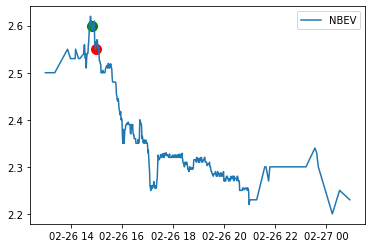

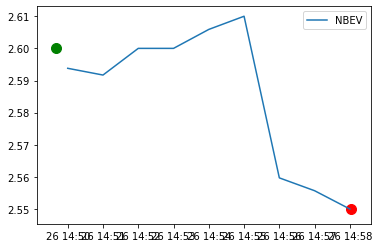

Delta = -0.050000000000000266


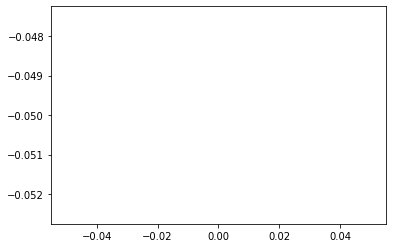

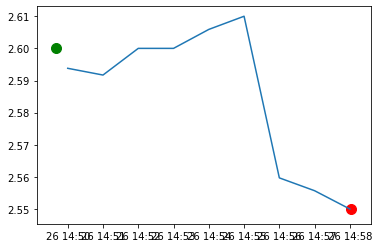

buy time:2020-02-26T14:49:40.785049467Z sell time:2020-02-26T14:58:02.35536263Z
{'rsi': 64.92461240572962, 'macd1': [0.01938456628324614, 0.02138598585858631, 0.024305776285322267, 0.02538303914062423, 0.02567453523363117], 'macd2': [0.005505262842163905, 0.006460154062675638, 0.007648224467372788, 0.00854192982656432, 0.009297726832639519], 'sell_macd': [0.012279348175391558, 0.013509847269105535, 0.015332186208764309, 0.01594527906812493, 0.01604450364596266], 'macd_signal': [0.012219482825522054, 0.014052783432134905, 0.01610338200277238, 0.01795931343034275, 0.019502357791000433], 'sell_macd_signal': [0.007794518883621368, 0.008937584560718201, 0.010216504890327422, 0.011362259725886923, 0.01229870850990207]}
{'rsi': 42.62002181165652, 'macd': [0.012471267804575525, 0.012320207257785931, 0.009429508036160605, 0.006846761785073596, 0.004449209358446726], 'scalp': 0, 'bail_out': 0, 'movement': -0.021113243761996223, 'too_close': 1, 'macd_signal': [0.013063371324076997, 0.012914738510

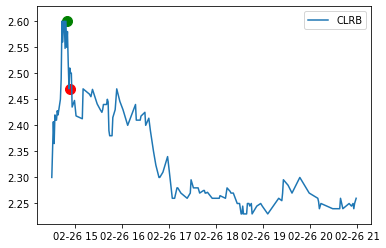

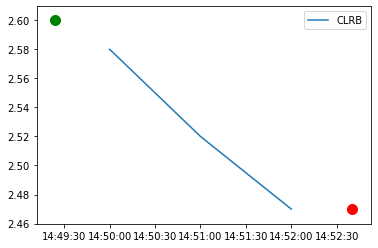

Delta = -0.1299999999999999


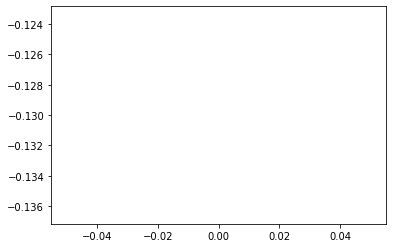

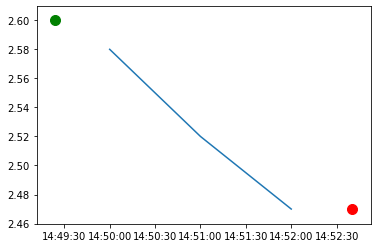

buy time:2020-02-26T14:49:23.704503175Z sell time:2020-02-26T14:52:40.313045611Z
{'rsi': 66.69902953907274, 'macd1': [0.06543735843279475, 0.07130266312994449, 0.0709612048370567, 0.07405708560659408, 0.075638677826527], 'macd2': [0.039903033348422046, 0.04247225490528894, 0.04394122323105032, 0.04605890864674489, 0.04793358218010235], 'sell_macd': [0.03958384469713616, 0.04326806745632705, 0.04289125314587405, 0.04475748546050928, 0.045630426413984626], 'macd_signal': [0.05250468276647554, 0.05626427883916933, 0.05920366403874681, 0.062174348352316264, 0.06486721424715841], 'sell_macd_signal': [0.03155274331648818, 0.033895808144455954, 0.03569489714473957, 0.03750741480789351, 0.03913201712911173]}
{'rsi': 51.43599377049151, 'macd': [0.04475748546050928, 0.04303302381658236, 0.04268885858993032, 0.0387493940160466, 0.032579039880344496], 'scalp': 0, 'bail_out': 0, 'movement': -0.049999999999999954, 'too_close': 1, 'macd_signal': [0.03750741480789351, 0.03861253660963128, 0.0394278010

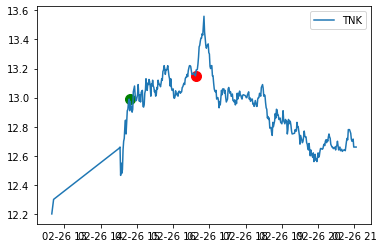

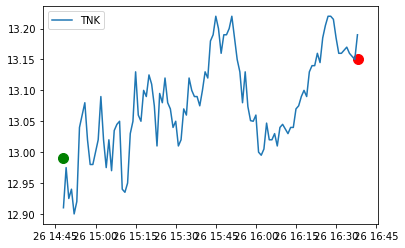

Delta = 0.16000000000000014


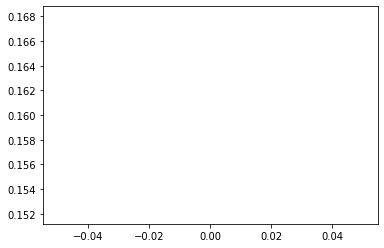

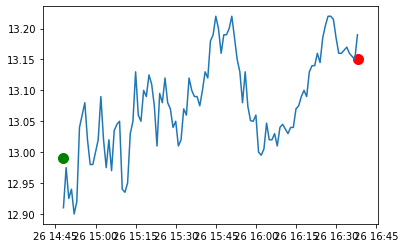

buy time:2020-02-26T14:47:49.913800842Z sell time:2020-02-26T16:38:03.489295137Z
{'rsi': 67.79992071818683, 'macd1': [0.12140802492198155, 0.13072346817554426, 0.13732988704171945, 0.14492944726972823, 0.15401822582706082], 'macd2': [0.04405658121674705, 0.049231063288900145, 0.05407295013211133, 0.05924083890688081, 0.06486033059625207], 'sell_macd': [0.0755001111880027, 0.08116514005004838, 0.08504483604579782, 0.08956089998994265, 0.09503366540109504], 'macd_signal': [0.09445572652541226, 0.10170927485543865, 0.10883339729269481, 0.11605260728810149, 0.12364573099589335], 'sell_macd_signal': [0.05922796012425231, 0.06361539610941153, 0.06790128409668879, 0.07223320727533956, 0.07679329890049066]}
{'rsi': 52.28317997299827, 'macd': [0.020815829021426424, 0.018633357081885293, 0.017210218465596228, 0.015358289433867967, 0.013196289026886632], 'scalp': 0, 'bail_out': 1, 'movement': 0.0030511060259344716, 'too_close': 1, 'macd_signal': [0.017978536312484975, 0.018109500466365037, 0.0179

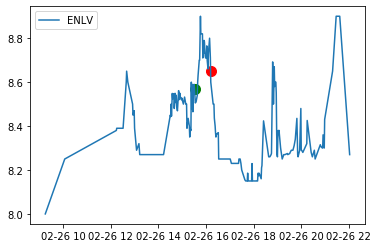

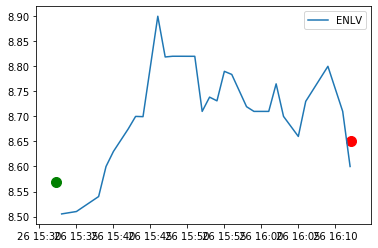

Delta = 0.08000000000000007


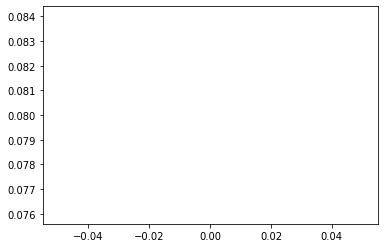

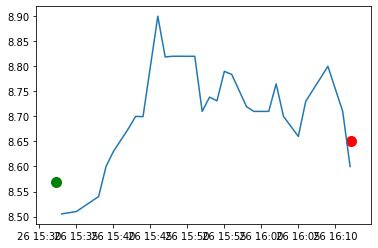

buy time:2020-02-26T15:32:17.452011609Z sell time:2020-02-26T16:12:08.405853082Z
{'rsi': 55.823767908773256, 'macd1': [0.022201393801402958, 0.02612700780035837, 0.0289048876251794, 0.03434163235829679, 0.03701325136734113], 'macd2': [0.05408443671274732, 0.05446037194891673, 0.0547191426368947, 0.05558941644036963, 0.056061284635504194], 'sell_macd': [0.0098686312663947, 0.01264388672072414, 0.014642217117335932, 0.018346861359924915, 0.020216105427397935], 'macd_signal': [0.02380660210425215, 0.024270683243473395, 0.025197524119814595, 0.027026345767511034, 0.029023726887477053], 'sell_macd_signal': [0.009921965138567579, 0.01046634945499889, 0.0113015229874663, 0.012710590661958022, 0.014211693615046005]}
{'rsi': 46.55932000051775, 'macd': [0.017115096938864482, 0.016051066542861037, 0.01864986017528736, 0.015757363522954648, 0.010181945826033711], 'scalp': 0, 'bail_out': 0, 'movement': -0.017045454545454586, 'too_close': 1, 'macd_signal': [0.030231257797276333, 0.027395219546393273

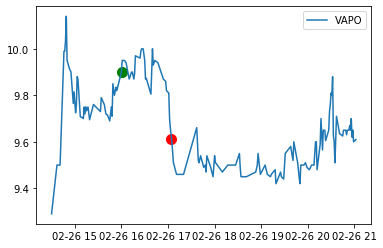

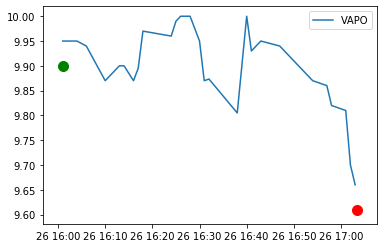

Delta = -0.2900000000000009


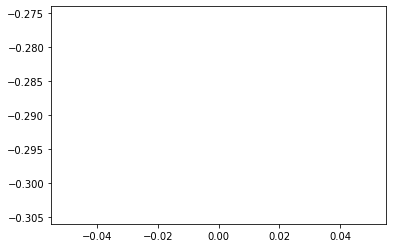

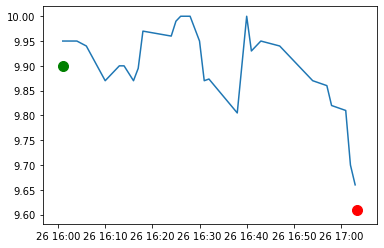

buy time:2020-02-26T16:00:58.073123332Z sell time:2020-02-26T17:03:26.880471064Z
{'rsi': 61.248124554259654, 'macd1': [0.021414372611976873, 0.023876495492940464, 0.028325435123404574, 0.030291693407974662, 0.03786877105647868], 'macd2': [0.051010236616543025, 0.051124981932478164, 0.05170856011889846, 0.05192286606311214, 0.053316479223200375], 'sell_macd': [0.009753077311273728, 0.011545082638310333, 0.014609696105633674, 0.01602874950737032, 0.021082183982652936], 'macd_signal': [0.024170430352257206, 0.024111643380393857, 0.024954401728996, 0.026021860064791732, 0.02839124226312912], 'sell_macd_signal': [0.010723731715027255, 0.01088800189968387, 0.01163234074087383, 0.01251162249417313, 0.014225734791869091]}
{'rsi': 31.28104577778859, 'macd': [0.008010425197706894, 0.0026516304554071723, -0.0020779710380143257, -0.011450673876549189, -0.02380017383025823], 'scalp': 0, 'bail_out': 0, 'movement': -0.015384615384615422, 'too_close': 1, 'macd_signal': [0.016849650109113434, 0.0140100

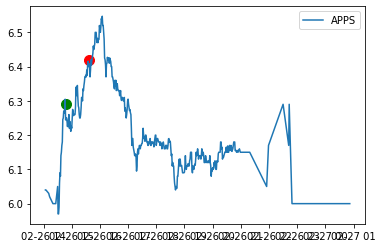

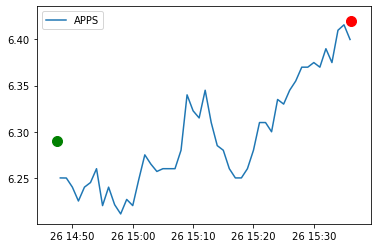

Delta = 0.1299999999999999


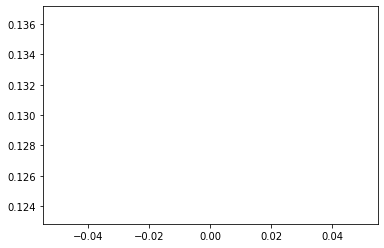

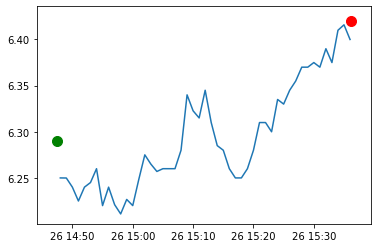

buy time:2020-02-26T14:47:22.671167435Z sell time:2020-02-26T15:36:12.07065181Z
{'rsi': 72.52777426474267, 'macd1': [0.0676704340079981, 0.07143464877885997, 0.07436747062179894, 0.07819498094749999, 0.07912200492407528], 'macd2': [0.017228796206921082, 0.019946895474213022, 0.02257566749826001, 0.025434724578364154, 0.02778776393982163], 'sell_macd': [0.04319467153355738, 0.04536892330070508, 0.04699341918029187, 0.04919700792827797, 0.04950633671984761], 'macd_signal': [0.0425917877593971, 0.048360359963289676, 0.05356178209499153, 0.058488421865493224, 0.06261513847720963], 'sell_macd_signal': [0.027535629576198394, 0.03110228832109973, 0.03428051449293816, 0.03726381318000612, 0.03971231788797442]}
{'rsi': 72.14951030141296, 'macd': [0.017893836802725716, 0.01889395122232962, 0.018648664390561898, 0.020033523165930767, 0.02137193879393351], 'scalp': 1, 'bail_out': 0, 'movement': 0.020667726550079476, 'too_close': 0, 'macd_signal': [0.014639519422519138, 0.015490405782481235, 0.0161

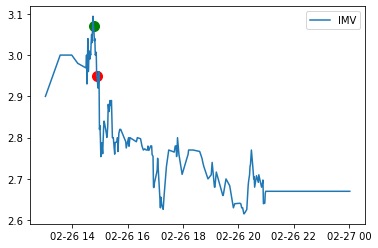

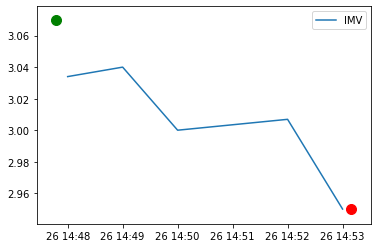

Delta = -0.11999999999999966


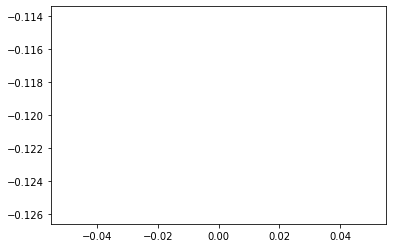

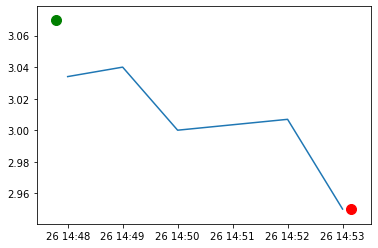

buy time:2020-02-26T14:47:47.598823531Z sell time:2020-02-26T14:53:09.625228497Z
{'rsi': 61.73947822481477, 'macd1': [0.03151245260746105, 0.03486699087402867, 0.035502404149840405, 0.0407090395750509, 0.04240188454266569], 'macd2': [-0.002022737511141237, -0.00017370738319533174, 0.0012078652493263675, 0.003502214376249757, 0.0052220418386830225], 'sell_macd': [0.020635779687964373, 0.022648487170480625, 0.022883733427370156, 0.026099720985629737, 0.027014779849395598], 'macd_signal': [0.020448992270259432, 0.023332591991013278, 0.025766554422778705, 0.028755051453233142, 0.03148441807111965], 'sell_macd_signal': [0.013946791224162005, 0.015687130413425728, 0.017126451016214614, 0.01892110501009764, 0.02053983997795723]}
{'rsi': 45.00509801001829, 'macd': [0.0251087980484499, 0.02401400746486093, 0.02077113158849464, 0.0183329019239431, 0.013239048913592288], 'scalp': 0, 'bail_out': 0, 'movement': -0.03908794788273605, 'too_close': 1, 'macd_signal': [0.021370514708938835, 0.0218992132

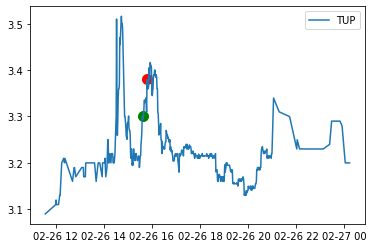

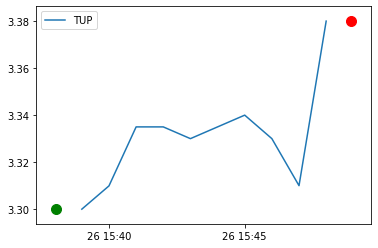

Delta = 0.08000000000000007


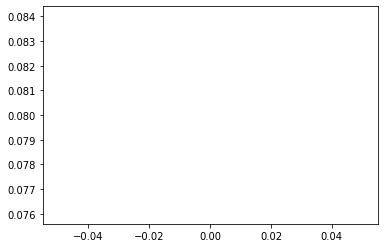

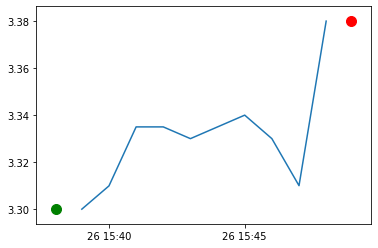

buy time:2020-02-26T15:38:01.956440535Z sell time:2020-02-26T15:48:55.758679034Z
{'rsi': 69.13968165664812, 'macd1': [-0.00543918076808847, -0.0014730203616277748, 0.004347453123338507, 0.00895383601756139, 0.012460787447308164], 'macd2': [-0.0027959704485764902, -0.002206652590437841, -0.0011203483113741974, -9.992946316517148e-05, 0.0008390483407461069], 'sell_macd': [-0.0023322253754276545, 0.00021454547893995368, 0.003952100099499756, 0.00687549201033244, 0.009064167629028841], 'macd_signal': [-0.012510085267391247, -0.010302672286238553, -0.00737264720432314, -0.004107350559946234, -0.0007937229584953544], 'sell_macd_signal': [-0.006993984776597592, -0.005552278725490083, -0.0036514029604921153, -0.0015460239663272041, 0.0005760143527440051]}
{'rsi': 73.71093473969663, 'macd': [0.017848004329494405, 0.01842990146474044, 0.0181244979147408, 0.016612176993770156, 0.019114106445042633], 'scalp': 1, 'bail_out': 0, 'movement': 0.025757575757575746, 'too_close': 0, 'macd_signal': [0.011

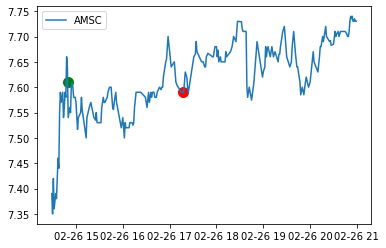

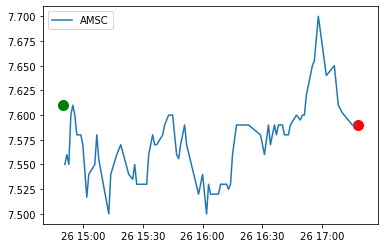

Delta = -0.020000000000000462


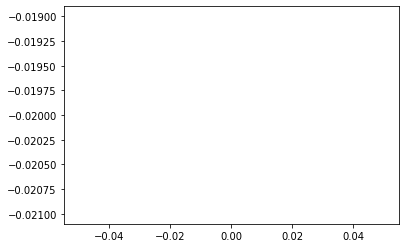

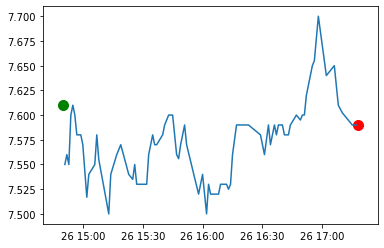

buy time:2020-02-26T14:50:03.040276178Z sell time:2020-02-26T17:17:40.910786917Z
{'rsi': 66.11461841312148, 'macd1': [0.050217601505642584, 0.05252584525831594, 0.05293799241202546, 0.05903938414314158, 0.06155142172002037], 'macd2': [0.009381136345533392, 0.011424313923266816, 0.013125895031092405, 0.015949899248997923, 0.01820269177534861], 'sell_macd': [0.03187353473715682, 0.03317474356532557, 0.03323835117733598, 0.037012092807768404, 0.038433033132680094], 'macd_signal': [0.03527085656649481, 0.03872185430485904, 0.041565081926292324, 0.045059942369662175, 0.048358238239733814], 'sell_macd_signal': [0.022685406886846043, 0.024783274222541948, 0.026474289613500755, 0.028581850252354286, 0.030552086828419447]}
{'rsi': 45.28976675483284, 'macd': [0.015618478941448188, 0.012808084825438826, 0.010051828568477639, 0.007134592153073882, 0.00476876387934233], 'scalp': 0, 'bail_out': 1, 'movement': 0.005298013245033118, 'too_close': 1, 'macd_signal': [0.013151921846182567, 0.0130831544420

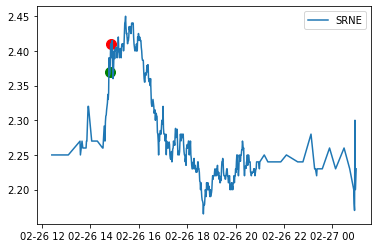

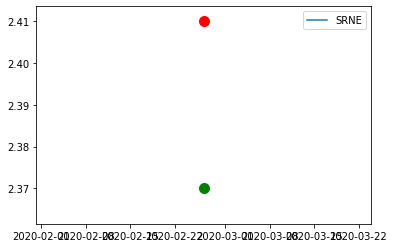

Delta = 0.040000000000000036


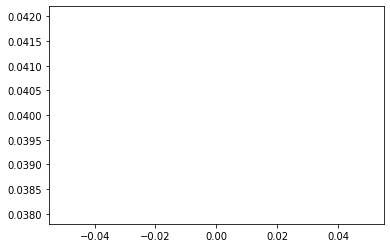

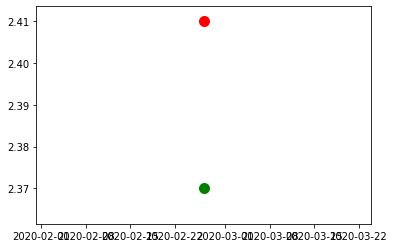

buy time:2020-02-26T14:49:02.507603072Z sell time:2020-02-26T14:50:57.845308901Z
{'rsi': 73.02116952950226, 'macd1': [0.018843399515541925, 0.020037163059701157, 0.02273840614347611, 0.024898771452491086, 0.026403345168072967], 'macd2': [0.004976009224114453, 0.005765679117906597, 0.006882819345473301, 0.007960391671042899, 0.008958253468104527], 'sell_macd': [0.011924890579181113, 0.012628860495873973, 0.014312098606337642, 0.015635243905317786, 0.016525548762895692], 'macd_signal': [0.01317571958762129, 0.014548008282037264, 0.016186087854325033, 0.017928624573958243, 0.019623568692781188], 'sell_macd_signal': [0.008439420096378044, 0.00927730817627723, 0.010284266262289312, 0.011354461790895007, 0.012388679185295143]}
{'rsi': 79.26789132216553, 'macd': [0.012628860495873973, 0.014312098606337642, 0.015635243905317786, 0.0170658085031552, 0.019496562624806035], 'scalp': 0, 'bail_out': 0, 'movement': 0.016877637130801704, 'too_close': 0, 'macd_signal': [0.00927730817627723, 0.01028426

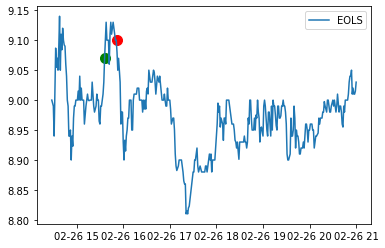

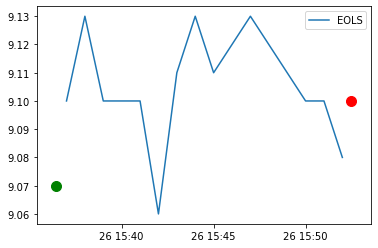

Delta = 0.02999999999999936


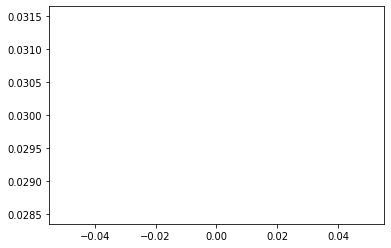

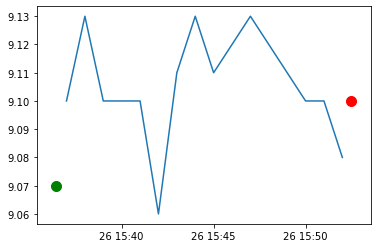

buy time:2020-02-26T15:36:26.7950139Z sell time:2020-02-26T15:52:29.465777278Z
{'rsi': 65.72200289170702, 'macd1': [-0.0016925501916702501, -0.0007127538015723189, 0.0008607362909724969, 0.003679160308882601, 0.009036282712555632], 'macd2': [0.02378319514677152, 0.02330575506765875, 0.02298915665010348, 0.022980980086570568, 0.02357644662274261], 'sell_macd': [-0.0019441133255959642, -0.0012359859944268692, -0.0001486661780027987, 0.0017394877851604207, 0.005266107915090856], 'macd_signal': [0.0013632389065776095, 0.0009480403649476238, 0.0009305795501525985, 0.001480295701898599, 0.0029914931040300055], 'sell_macd_signal': [-0.0002592478499449991, -0.0004545954788413731, -0.0003934096186736582, 3.31698620931576e-05, 0.0010797574726926972]}
{'rsi': 56.69254881858258, 'macd': [0.019991033878453024, 0.019055684645042703, 0.017559884143098614, 0.016166274867000396, 0.01487039393929912], 'scalp': 0, 'bail_out': 1, 'movement': 0.00330760749724359, 'too_close': 1, 'macd_signal': [0.017011382

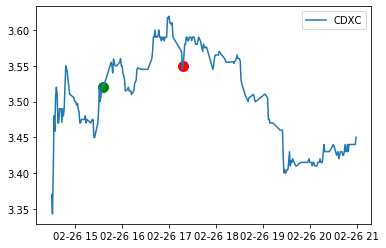

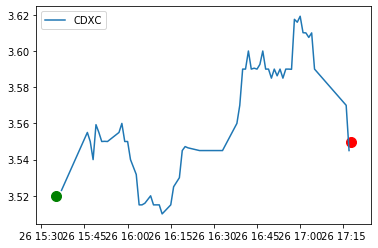

Delta = 0.029999999999999805


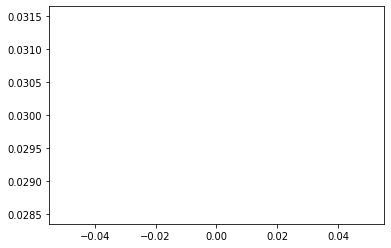

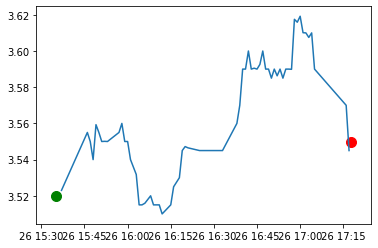

buy time:2020-02-26T15:35:13.808351931Z sell time:2020-02-26T17:17:43.868905029Z
{'rsi': 62.67892987518098, 'macd1': [0.002558250795772654, 0.0040672660174241315, 0.005825414512821148, 0.007647036103086258, 0.009441787649839384], 'macd2': [0.008228580274719732, 0.008452144722149058, 0.008769063240600339, 0.009148972580061976, 0.00957503235606394], 'sell_macd': [0.000869512962983432, 0.0019064256369807353, 0.0030948455694859156, 0.004313161808197297, 0.0055025879447492265], 'macd_signal': [0.0005167950915804546, 0.00122688927674919, 0.0021465943239635816, 0.003246682679788117, 0.00448570367379837], 'sell_macd_signal': [-0.0007746816323716821, -0.00023846017850119854, 0.00042820097109622427, 0.0012051931385164388, 0.0020646720997629965]}
{'rsi': 31.49479248270713, 'macd': [0.007543361424679151, 0.0072624946900803344, 0.005910358342470001, 0.0037410266645596657, 0.0007033522835313555], 'scalp': 0, 'bail_out': 0, 'movement': -0.015277777777777822, 'too_close': 1, 'macd_signal': [0.00775017

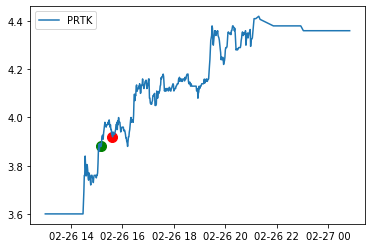

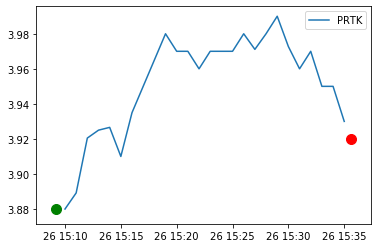

Delta = 0.040000000000000036


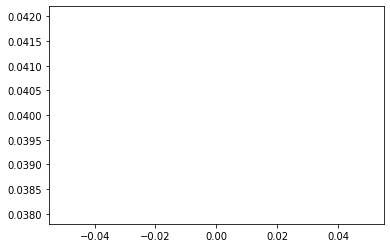

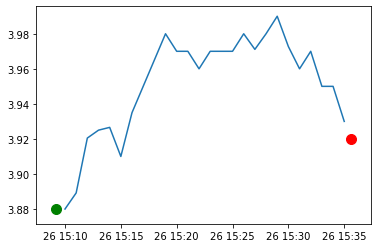

buy time:2020-02-26T15:09:13.039242879Z sell time:2020-02-26T15:35:37.571138107Z
{'rsi': 71.20085637814039, 'macd1': [0.03016274203057634, 0.0365684536764217, 0.03877727671887676, 0.04245909218839117, 0.04564958473928282], 'macd2': [0.049410574551255415, 0.05059158701582378, 0.0511174340101892, 0.05199928294981149, 0.05288578326099547], 'sell_macd': [0.016352150538630816, 0.02060312598171299, 0.022089559755781085, 0.024519383998486077, 0.026608605694120158], 'macd_signal': [0.02727518833845696, 0.029133841406049906, 0.031062528468615277, 0.03334184121257046, 0.03580338991791293], 'sell_macd_signal': [0.014030354636499176, 0.01534490890554194, 0.01669383907558977, 0.01825894806016903, 0.019928879586959256]}
{'rsi': 45.50199407438003, 'macd': [0.01887823348556772, 0.01747096196039566, 0.015108530097139639, 0.013071459423211085, 0.009755930853614814], 'scalp': 0, 'bail_out': 0, 'movement': -0.015075376884422124, 'too_close': 1, 'macd_signal': [0.023410056241618064, 0.022222237385373583, 0

In [19]:
for run_id, count in runs.items():
    for symbol in minute_history:
        if symbol not in trade_details[run_id]:
            print(symobl)
            continue
        print (f'{symbol} analysis for run {run_id}')
        plt.plot(minute_history[symbol]['close'], label=symbol)


        for trade in trade_details[run_id][symbol]:
            print(trade[0], trade[1])
            plt.scatter(parser.isoparse(trade[0]), trade[1], c='g', s=100)
            plt.scatter(parser.isoparse(trade[2]), trade[3], c='r', s=100)

        plt.legend()
        plt.show()

        min_time = trade_details[run_id][symbol][0][0]
        max_time = trade_details[run_id][symbol][-1][2]
        delta = 0 
        accumulative_delta = []
        plt.plot(minute_history[symbol]['close'][min_time:max_time], label=symbol)
        for trade in trade_details[run_id][symbol]:
            plt.scatter(parser.isoparse(trade[0]), trade[1], c='g', s=100)
            plt.scatter(parser.isoparse(trade[2]), trade[3], c='r', s=100)
            trade_delta = trade[3] - trade[1]
            delta += trade_delta 
            accumulative_delta.append(delta)
        plt.legend()
        plt.show()

        print(f'Delta = {delta}')
        plt.plot(range(len(accumulative_delta)), accumulative_delta)
        plt.show()

        for trade in trade_details[run_id][symbol]:
            plt.plot(minute_history[symbol]['close'][trade[0]:trade[2]])
            plt.scatter(parser.isoparse(trade[0]), trade[1], c='g', s=100)
            plt.scatter(parser.isoparse(trade[2]), trade[3], c='r', s=100)
            plt.show()
            print(f"buy time:{trade[0]} sell time:{trade[2]}")
            print(trade[4])
            print(trade[5])
